In [216]:
import importlib
import toy_models, eigenestimation_algorithm
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import einops
from eigenestimation_algorithm.evaluation import PrintFeatureVals, ActivatingExamples, PrintFeatureValsTransformer, PrintActivatingExamplesTransformer

importlib.reload(toy_models.xornet)
importlib.reload(toy_models.tms)
importlib.reload(toy_models.train)

importlib.reload(eigenestimation_algorithm.train)
importlib.reload(eigenestimation_algorithm.eigenestimation)
importlib.reload(eigenestimation_algorithm.evaluation)

importlib.reload(eigenestimation_algorithm)
import gc
# Toy models!
from toy_models.xornet import XORNet, GenerateXORData
from toy_models.tms import Autoencoder, GenerateTMSData
from toy_models.transformer_wrapper import TransformerWrapper, DeleteParams

from toy_models.train import TrainModel
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import torch
import copy
import matplotlib.pyplot as plt
from eigenestimation_algorithm.eigenestimation import EigenEstimation
from eigenestimation_algorithm.train import TrainEigenEstimation

device='cuda'
torch.set_default_device(device)


# Toy Models

## XORNet

In [95]:
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=24)
model_xornet = XORNet()

In [96]:
_, _, _ =TrainModel(
    model=model_xornet,
    criterion=nn.MSELoss(),
    learning_rate=.01,
    dataloader=dataloader_xornet,
    n_epochs=1000
)

Epoch 300, Loss: 8.041374144340807e-07


## TMS

Epoch 500, Loss: 0.10686875879764557
Epoch 1000, Loss: 0.026212189346551895
Epoch 1500, Loss: 0.039112016558647156
Epoch 2000, Loss: 0.050186965614557266
Epoch 2500, Loss: 0.012528285384178162
Epoch 3000, Loss: 0.010989688336849213
Epoch 3500, Loss: 0.028260987251996994
Epoch 4000, Loss: 0.04411494731903076
Epoch 4500, Loss: 0.03988216444849968


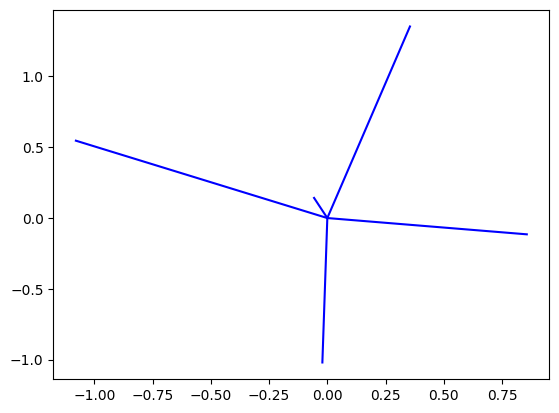

In [43]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 2048
sparsity = .1

batch_size = 24
learning_rate = .01
n_epochs = 5000

X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
tms_model = Autoencoder(n_features, hidden_dim)
_, _, _ = TrainModel(tms_model, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs)


# Plot TMS representations.
en = copy.deepcopy(tms_model.W).detach().cpu().numpy()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

## 2-layer transformer




In [151]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
config = GPT2Config.from_pretrained('gpt2', n_layer=2)
gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if p!='transformer.ln_f.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,_ in transformer_model.named_parameters(): print(n)

768
transformer.ln_f.weight


In [102]:
# Load in data.
imdb_dataset = load_dataset("imdb", split="test[:1%]")
X_transformer= tokenize_and_concatenate(imdb_dataset, tokenizer, max_length = 24, add_bos_token=False)['tokens']
transformer_dataloader = DataLoader(X_transformer, batch_size=24, shuffle=True,
                                    generator=torch.Generator(device='cuda'))

Map (num_proc=10): 100%|██████████| 250/250 [00:12<00:00, 20.63 examples/s]


# Eigenestimation

# Tests on Toy Models


## Xornet

In [98]:
n_u_vectors = 3
batch_size = 4
lambda_penalty = 1
repeats = 4
n_epochs = 100
learning_rate = .01

torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet = EigenEstimation(model_xornet, nn.MSELoss, n_u_vectors)

dataloader_xornet_eigen = DataLoader(
    einops.repeat(X_xornet, 's f -> (s r) f', r=repeats), batch_size=batch_size, shuffle=True,
    generator=torch.Generator(device=device))

TrainEigenEstimation(eigenmodel_xornet, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


/home/ubuntu/brianna-interpretability/eigenestimation/eigenestimation_algorithm/eigenestimation.py:31: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  outputs: torch.Tensor = stateless.functional_call(self.model, parameters, (x,))


Epoch 0 - Total Loss: -1.887, High Hessian Loss: -1.959,  Basis Loss: 0.073
Epoch 10 - Total Loss: -4.457, High Hessian Loss: -4.552,  Basis Loss: 0.095
Epoch 20 - Total Loss: -4.524, High Hessian Loss: -4.590,  Basis Loss: 0.066
Epoch 30 - Total Loss: -4.538, High Hessian Loss: -4.595,  Basis Loss: 0.056
Epoch 40 - Total Loss: -4.555, High Hessian Loss: -4.618,  Basis Loss: 0.063
Epoch 50 - Total Loss: -4.576, High Hessian Loss: -4.659,  Basis Loss: 0.082
Epoch 60 - Total Loss: -4.597, High Hessian Loss: -4.703,  Basis Loss: 0.106
Epoch 70 - Total Loss: -4.624, High Hessian Loss: -4.764,  Basis Loss: 0.139
Epoch 80 - Total Loss: -4.648, High Hessian Loss: -4.826,  Basis Loss: 0.178
Epoch 90 - Total Loss: -4.668, High Hessian Loss: -4.881,  Basis Loss: 0.213


276

In [99]:
#@title Look at features
PrintFeatureVals(X_xornet, eigenmodel_xornet)

for f_idx in range(eigenmodel_xornet.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet, eigenmodel_xornet, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

[0. 0.] --> [0.53 0.13 0.  ]
[0. 1.] --> [5.09 0.69 0.  ]
[1. 0.] --> [0.   0.28 6.94]
[1. 1.] --> [1.73 2.39 0.43]
feature 0
[0. 1.] -> 5.0876226
[1. 1.] -> 1.7256724
[0. 0.] -> 0.52878517
feature 1
[1. 1.] -> 2.3889158
[0. 1.] -> 0.68826383
[1. 0.] -> 0.2794086
feature 2
[1. 0.] -> 6.9396763
[1. 1.] -> 0.42713824
[0. 1.] -> 0.0023718486


## TMS

In [ ]:
#@title Train Eigenmodel
n_u_vectors = 5
batch_size = 24
lambda_penalty = 1
n_epochs = 1000
learning_rate = .01


dataloader = DataLoader(X_tms, batch_size=batch_size, shuffle=True,
                               generator=torch.Generator(device='cuda'))
eigenmodel_tms = EigenEstimation(tms_model, nn.MSELoss, n_u_vectors)
TrainEigenEstimation(eigenmodel_tms, dataloader, learning_rate, n_epochs, lambda_penalty)

epoch 0 - Total Loss: -0.952, High Hessian Loss: -1.087,  Basis loss: 0.135
epoch 100 - Total Loss: -6.515, High Hessian Loss: -7.165,  Basis loss: 0.650
epoch 200 - Total Loss: -7.087, High Hessian Loss: -7.382,  Basis loss: 0.294
epoch 300 - Total Loss: -7.549, High Hessian Loss: -7.697,  Basis loss: 0.148
epoch 400 - Total Loss: -7.657, High Hessian Loss: -7.777,  Basis loss: 0.119
epoch 500 - Total Loss: -7.706, High Hessian Loss: -7.812,  Basis loss: 0.107
epoch 600 - Total Loss: -7.720, High Hessian Loss: -7.818,  Basis loss: 0.099
epoch 700 - Total Loss: -7.731, High Hessian Loss: -7.826,  Basis loss: 0.095
epoch 800 - Total Loss: -7.718, High Hessian Loss: -7.811,  Basis loss: 0.093
epoch 900 - Total Loss: -7.748, High Hessian Loss: -7.841,  Basis loss: 0.093


In [ ]:
#@title Look at features
PrintFeatureVals(X_tms[:10], eigenmodel_tms)

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms, eigenmodel_tms, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

[0.   0.   0.   0.17 0.  ] --> [1.47 0.   0.   0.   0.  ]
[0.84 0.   0.   0.   0.  ] --> [1.44 0.   0.   9.07 1.82]
[0.   0.   0.   0.   0.64] --> [0.   1.58 5.98 0.   1.07]
[0.   0.   0.98 0.   0.  ] --> [0.000e+00 1.000e-02 1.970e+00 2.240e+00 1.112e+01]
[0.   0.24 0.   0.   0.  ] --> [0.01 1.99 0.   0.   0.  ]
[0.   0.56 0.   0.   0.  ] --> [1.14 5.31 0.85 0.   0.  ]
[0.   0.67 0.   0.   0.  ] --> [1.28 6.86 0.94 0.   0.  ]
[0.   0.   0.   0.49 0.  ] --> [4.19 0.   0.   0.   0.  ]
[0.   0.37 0.   0.72 0.  ] --> [8.44 4.09 0.   0.01 0.  ]
[0.93 0.   0.   0.   0.  ] --> [ 1.56  0.    0.   10.66  2.01]
feature 0
[0.    0.    0.    0.991 0.   ] -> 12.03
[0.    0.    0.    0.987 0.   ] -> 11.963
[0.    0.    0.    0.983 0.   ] -> 11.887
feature 1
[0.    0.946 0.    0.    0.   ] -> 11.289
[0.   0.93 0.   0.   0.  ] -> 11.011
[0.    0.777 0.    0.    0.522] -> 10.621
feature 2
[0.    0.    0.906 0.    0.935] -> 15.038
[0.    0.    0.    0.    0.997] -> 11.808
[0.   0.   0.   0.   0.99] -> 

## 2L Transformer

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KLDivergenceLoss(nn.Module):
    def __init__(self, reduction: str = 'mean') -> None:
        """
        KL Divergence Loss with a structure similar to MSELoss.
        
        Args:
            reduction (str): Specifies the reduction to apply to the output:
                             'none' | 'mean' | 'sum'. Default is 'mean'.
        """
        super(KLDivergenceLoss, self).__init__()
        self.reduction = reduction

    def forward(self, preds: torch.Tensor, truth: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for KL Divergence Loss.
        
        Args:
            preds (torch.Tensor): Predicted logits or probabilities (not softmaxed).
            truth (torch.Tensor): Target probabilities.

        Returns:
            torch.Tensor: The computed KL Divergence Loss.
        """
        # Convert preds to log-probabilities
        preds_log = torch.log_softmax(preds, dim=1)

        # Compute KL divergence per sample (without reduction)
        kl_divergence = F.kl_div(preds_log, truth, reduction='none')
        per_sample_kl_div = kl_divergence.mean(dim=1)  # Sum over classes for each sample

        # Apply reduction
        if self.reduction == 'mean':
            return per_sample_kl_div.mean()
        elif self.reduction == 'sum':
            return per_sample_kl_div.sum()
        else:  # 'none'
            return per_sample_kl_div


In [161]:
#@title Train Eigenmodel
#model = transformer_model
n_u_vectors = 10
batch_size = 4
lambda_penalty = 1
n_epochs = 10
learning_rate = .001

torch.cuda.empty_cache()
gc.collect()

transformer_dataloader = DataLoader(X_transformer[:1000, :10], batch_size=batch_size, shuffle=True,
                                    generator=torch.Generator(device='cuda'))
eigenmodel_transformer = EigenEstimation(transformer_model, KLDivergenceLoss, n_u_vectors)
TrainEigenEstimation(eigenmodel_transformer, transformer_dataloader, learning_rate, n_epochs, lambda_penalty)

Epoch 0 - Total Loss: -0.000, High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 1 - Total Loss: -0.000, High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 2 - Total Loss: -0.000, High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 3 - Total Loss: -0.000, High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 4 - Total Loss: -0.000, High Hessian Loss: -0.000,  Basis Loss: 0.000


KeyboardInterrupt: 

In [ ]:
PrintFeatureValsTransformer(eigenmodel_transformer, X_transformer[:100,:2], 2, 4)


In [200]:
gc.collect()
X = X_transformer[:2,:3]
eigenmodel= eigenmodel_transformer
feature_idx=1
dH, _ = eigenmodel(X)
feature_vals = einops.rearrange(dH, '(s t) f -> s t f', s=X.shape[0], t=X.shape[1])[:,:,feature_idx]
feature_vals.argmax()

/home/ubuntu/brianna-interpretability/eigenestimation/eigenestimation_algorithm/eigenestimation.py:31: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  outputs: torch.Tensor = stateless.functional_call(self.model, parameters, (x,))


tensor([[-1.1149e-03, -2.4052e-05, -1.7928e-04],
        [-1.0913e-03, -9.6563e-15, -7.5721e-15]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [209]:
tokens

', st'

# --------


# --------

# Singular Basis

# Eigenestimation_old

In [5]:
# HVP

import torch
import torch.nn as nn
from torch.func import functional_call
import einops

class EigenEstimation(nn.Module):
    def __init__(self, model, loss, n_u_vectors):
        super(EigenEstimation, self).__init__()

        self.loss = loss
        self.model = model
        self.w0 = dict(model.named_parameters())
        self.n_u_vectors = n_u_vectors

        u_dict = {
            name: torch.nn.Parameter(torch.stack([torch.randn_like(param) for _ in range(n_u_vectors)]))
            for name, param in self.w0.items()
        }

        for name, tensor in u_dict.items():
            # Register each tensor as a parameter
            self.register_parameter(name.replace('.', '__'), tensor)

    def compute_loss(self, x, parameters):
        outputs = functional_call(self.model, parameters, (x,))
        truth = outputs.detach()
        return self.loss(reduction='none')(outputs, truth)

    def grad_along_u(self, x, w0, u):
        # Collect parameter names
        param_names = list(w0.keys())
        # Collect parameters into a tuple
        params_tuple = tuple(w0[name] for name in param_names)
        # Collect u vectors into a tuple
        u_tuple = tuple(u[name.replace('.', '__')] for name in param_names)

        # Define the loss function
        def loss_fn(*params_tuple):
            parameters = dict(zip(param_names, params_tuple))
            loss = self.compute_loss(x, parameters).sum()  # Sum over batch
            return loss

        # Compute the jvp
        _, jvp_result = torch.autograd.functional.jvp(
            loss_fn,
            params_tuple,
            u_tuple,
            create_graph=True
        )

        grad_along_u = jvp_result  # Scalar value
        return grad_along_u

    def double_grad_along_u(self, x, u):
        # Collect parameter names
        param_names = list(self.w0.keys())
        # Collect parameters into a tuple
        params_tuple = tuple(self.w0[name] for name in param_names)
        # Collect u vectors into a tuple
        dots = []
        for vector_idx in range(self.n_u_vectors):
          u_tuple = tuple(u[name.replace('.', '__')][vector_idx] for name in param_names)

          # Define the gradient function
          def grad_fn(*params_tuple):
              parameters = dict(zip(param_names, params_tuple))
              loss = self.compute_loss(x, parameters)  # Sum over batch
              grads = torch.autograd.grad(loss, params_tuple, create_graph=True)
              return grads  # Returns a tuple of gradients

          # Compute the Hessian-vector product
          _, hvp = torch.autograd.functional.jvp(
              grad_fn,
              params_tuple,
              u_tuple,
              create_graph=False
          )


          # Compute the dot product between hvp and u
          print(hvp, x)
          dot = sum((hvp_i * u_i).sum() for hvp_i, u_i in zip(hvp, u_tuple))
          dots.append(dot)
        return torch.stack(dots)  # Scalar value

    def normalize_parameters(self):
        u_tensor = self.params_to_vectors(self._parameters)  # Shape: [n_u_vectors, total_param_size]
        norms = u_tensor.norm(dim=1, keepdim=True)  # Shape: [n_u_vectors, 1]
        normalized_params = {}
        for name, param in self._parameters.items():
            # Reshape norms to match the dimensions of param
            param_shape = param.shape[1:]  # Exclude n_u_vectors dimension
            norms_reshaped = norms.view(-1, *([1] * len(param_shape)))  # Shape: [n_u_vectors, 1, 1, ...]
            # Normalize param
            normalized_params[name] = param / norms_reshaped
        return normalized_params

    def params_to_vectors(self, params):
        # Concatenate all parameters into a single tensor
        return torch.cat([param.view(param.size(0), -1) for param in params.values()], dim=1)

    def forward(self, x):
        # Normalize u parameters
        params = self.normalize_parameters()
        # Compute u_tensor
        u_tensor = self.params_to_vectors(params)

        # Compute dH_du
        dH_du = self.double_grad_along_u(x, params)

        return dH_du, u_tensor


import torch
from torch.autograd.functional import hvp
from torch.func import vmap

# Model definition (as before)
class MyModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        output = self.linear2(x)
        return output

model = MyModel(input_dim=10, hidden_dim=20, output_dim=1)

# Inputs
batch_size = 5
X_batch = torch.randn(batch_size, 10)

# Get model parameters
param_names = [name for name, _ in model.named_parameters()]
params = [param for _, param in model.named_parameters()]

# Number of vectors
n_vectors = 3

# Prepare random vectors
vectors = []
for _ in range(n_vectors):
    vector = [torch.randn_like(param) for param in params]
    vectors.append(vector)

# Flatten parameters and vectors
def flatten_params(params):
    return torch.cat([p.reshape(-1) for p in params])

params_flat = flatten_params(params)
vectors_flat = [flatten_params(v) for v in vectors]
vectors_flat = torch.stack(vectors_flat)  # Shape: [n_vectors, total_params]

# Prepare targets (using model outputs as targets for simplicity)
with torch.no_grad():
    y_samples = model(X_batch).squeeze(-1)  # Shape: [batch_size]

# Function to compute hvp dot product per sample and vector
def hvp_per_sample(params_flat, x_sample, y_sample, vector_flat):
    # Unflatten parameters
    param_idx = 0
    params_unflat = []
    for param in params:
        numel = param.numel()
        param_unflat = params_flat[param_idx:param_idx+numel].view_as(param)
        params_unflat.append(param_unflat)
        param_idx += numel

    # Unflatten vector
    param_idx = 0
    vector_unflat = []
    for param in params:
        numel = param.numel()
        vector_unflat.append(vector_flat[param_idx:param_idx+numel].view_as(param))
        param_idx += numel

    # Compute loss for the sample
    def single_loss_fn(*params_unflat):
        param_dict = dict(zip(param_names, params_unflat))
        y_pred = torch.func.functional_call(model, param_dict, (x_sample.unsqueeze(0),))
        loss = torch.nn.functional.mse_loss(y_pred.squeeze(0), y_sample, reduction='sum')
        return loss

    # Compute Hessian-vector product
    _, hvp_tensor = hvp(single_loss_fn, tuple(params_unflat), tuple(vector_unflat))
    hvp_flat = flatten_params(hvp_tensor)
    hvp_dot = torch.dot(hvp_flat, vector_flat)
    return hvp_dot

# Vectorize over batch and vectors
def compute_hvp_dot(x_sample, vector_flat):
    hvp_dot = hvp_per_sample(params_flat, x_sample, x_sample, vector_flat)
    return hvp_dot

compute_hvp_dot_vmap = vmap(vmap(compute_hvp_dot, in_dims=(None, 0)), in_dims=(0, None))

# Compute Hessian-vector products
batch_indices = torch.arange(batch_size)
vector_indices = torch.arange(n_vectors)
hvp_results = compute_hvp_dot_vmap(X,  vectors_flat)
# Shape: [batch_size, n_vectors]

print("Hessian-vector products shape:", hvp_results.shape)
print("Hessian-vector products:", hvp_results)


NameError: name 'X' is not defined

In [ ]:
import einops
class EigenEstimation(nn.Module):
    def __init__(self, k, model, criterion):
        super(EigenEstimation, self).__init__()

        n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(k, n))
        self.model = model
        self.criterion = criterion


    def forward(self, X_batch):
        # Normalize columns of U
        self.U.data = self.U.data / torch.norm(self.U.data, dim=1, keepdim=True)  # [n, k]

        U = self.U  # [n, k]
        model = self.model
        criterion = self.criterion
        loss = criterion(self.model(X_batch), self.model(X_batch).detach())

        H_vs = []
        grads = torch.cat([g.flatten() for g in torch.autograd.grad(
            loss, self.model.parameters(), create_graph=True)])
        grads_flat = torch.cat([g.view(-1) for g in grads])
        for i in range(U.shape[0]):

          # Hessian-vector product
          H_v = torch.autograd.grad(torch.dot(grads_flat,U[i,:]), self.model.parameters(), retain_graph=True)  #
          Hv_flat = torch.dot(U[i,:] ,torch.cat([h.view(-1) for h in H_v]))
          H_vs.append(Hv_flat) # 1 x k (k x n) = 1 x n

        # d2L/dv2
        H_vs_tensor = torch.stack(H_vs)

        # Magnitude and direction of each U vector.
        Hv_U = einops.repeat(H_vs_tensor, 'k->k n', n=U.shape[1]) * U

        # Dot product of U-vectors, scaled by magnitudes.
        dot_prods = Hv_U @ einops.rearrange(Hv_U, 'k n -> n k')

        return H_vs_tensor, dot_prods



def TrainEigenestimation(eigen_model, learning_rate, num_epochs, lambda_penalty, dataloader, criterion, hessian_samples):


  # Number of parameters in the model
  n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices

  # Create a mask for the lower triangular part (including diagonal) to be used for dot products.
  lower_triangular_mask = torch.tril(torch.ones(eigen_model.U.shape[0], eigen_model.U.shape[0], dtype=torch.bool), diagonal=-1)

  # Optimizer
  optimizer = torch.optim.SGD(eigen_model.parameters(), lr=learning_rate)
  eigen_model.train()

  # Training loop
  for epoch in range(num_epochs):
    total_losses = 0
    high_hessian_losses = 0
    orthogonality_losses = 0
    optimizer.zero_grad()
    n_batches = 0
    for X, Y in dataloader:

      total_loss = 0
      hessian_dataloader = DataLoader(TensorDataset(X, Y), batch_size=hessian_samples, shuffle=True,
                                      generator=torch.Generator(device='cuda'))
      n_subbatches = 0
      for X_batch, _ in hessian_dataloader:
        n_subbatches += 1
        # Compute d2L/du2 and dot product of u vectors scaled by magnitudes.
        H_vs, dot_prods = eigen_model(X_batch)

        # High hessian loss
        high_hessian_loss = -(H_vs**2).mean()

        # Orthgonality Loss
        orthogonality_loss = abs(torch.masked_select(dot_prods, lower_triangular_mask)).mean()

        # Compute losses
        total_loss = total_loss + high_hessian_loss + lambda_penalty * orthogonality_loss
        high_hessian_losses = high_hessian_losses + high_hessian_loss
        orthogonality_losses = orthogonality_losses + orthogonality_loss

      # Backward pass and optimization
      n_batches += n_subbatches
      (total_loss/n_subbatches).backward()
      optimizer.step()
      optimizer.zero_grad()

      total_losses = total_losses + total_loss


    # Print losses
    if (epoch) % round(num_epochs/10) == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total total_losses: {total_losses.item()/n_batches:.3f}, "
              f"High hessian Loss: {high_hessian_losses.item()/n_batches:.3f}, "
              f"orthogonality Term: {orthogonality_losses.item()/n_batches:.3f}")



In [ ]:
import einops
class EigenEstimation(nn.Module):
    def __init__(self, k, model, criterion):
        super(EigenEstimation, self).__init__()

        n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(k, n))
        self.model = model
        self.criterion = criterion


    def forward(self, X_batch):
        # Normalize columns of U
        self.U.data = self.U.data / torch.norm(self.U.data, dim=1, keepdim=True)  # [n, k]

        U = self.U  # [n, k]
        model = self.model
        criterion = self.criterion
        loss = criterion(self.model(X_batch), self.model(X_batch).detach())

        H_vs = []
        grads = torch.cat([g.flatten() for g in torch.autograd.grad(
            loss, self.model.parameters(), create_graph=True)])
        grads_flat = torch.cat([g.view(-1) for g in grads])
        for i in range(U.shape[0]):

          # Hessian-vector product
          H_v = torch.autograd.grad(torch.dot(grads_flat,U[i,:]), self.model.parameters(), retain_graph=True)  #
          Hv_flat = torch.dot(U[i,:] ,torch.cat([h.view(-1) for h in H_v]))
          H_vs.append(Hv_flat) # 1 x k (k x n) = 1 x n

        # d2L/dv2
        H_vs_tensor = torch.stack(H_vs)

        # Magnitude and direction of each U vector.
        Hv_U = einops.repeat(H_vs_tensor, 'k->k n', n=U.shape[1]) * U

        # Dot product of U-vectors, scaled by magnitudes.
        dot_prods = Hv_U @ einops.rearrange(Hv_U, 'k n -> n k')

        return H_vs_tensor, dot_prods



def TrainEigenestimation(eigen_model, learning_rate, num_epochs, lambda_penalty, dataloader, criterion, hessian_samples):


  # Number of parameters in the model
  n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices

  # Create a mask for the lower triangular part (including diagonal) to be used for dot products.
  lower_triangular_mask = torch.tril(torch.ones(eigen_model.U.shape[0], eigen_model.U.shape[0], dtype=torch.bool), diagonal=-1)

  # Optimizer
  optimizer = torch.optim.SGD(eigen_model.parameters(), lr=learning_rate)
  eigen_model.train()

  # Training loop
  for epoch in range(num_epochs):
    total_losses = 0
    high_hessian_losses = 0
    orthogonality_losses = 0
    optimizer.zero_grad()
    n_batches = 0
    for X, Y in dataloader:

      total_loss = 0
      hessian_dataloader = DataLoader(TensorDataset(X, Y), batch_size=hessian_samples, shuffle=True,
                                      generator=torch.Generator(device='cuda'))
      n_subbatches = 0
      for X_batch, _ in hessian_dataloader:
        n_subbatches += 1
        # Compute d2L/du2 and dot product of u vectors scaled by magnitudes.
        H_vs, dot_prods = eigen_model(X_batch)

        # High hessian loss
        high_hessian_loss = -(H_vs**2).mean()

        # Orthgonality Loss
        orthogonality_loss = abs(torch.masked_select(dot_prods, lower_triangular_mask)).mean()

        # Compute losses
        total_loss = total_loss + high_hessian_loss + lambda_penalty * orthogonality_loss
        high_hessian_losses = high_hessian_losses + high_hessian_loss
        orthogonality_losses = orthogonality_losses + orthogonality_loss

      # Backward pass and optimization
      n_batches += n_subbatches
      (total_loss/n_subbatches).backward()
      optimizer.step()
      optimizer.zero_grad()

      total_losses = total_losses + total_loss


    # Print losses
    if (epoch) % round(num_epochs/10) == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total total_losses: {total_losses.item()/n_batches:.3f}, "
              f"High hessian Loss: {high_hessian_losses.item()/n_batches:.3f}, "
              f"orthogonality Term: {orthogonality_losses.item()/n_batches:.3f}")



## XORNet

In [ ]:
#@title Train XORNet
starting_params = []
ending_params = []
losses = []

model = XORNet()
xornet_model, params, loss = TrainModel(model, nn.MSELoss(), .01, dataloader_xornet, n_epochs=10000)


Epoch 1000, Loss: 0.014485098421573639
Epoch 2000, Loss: 0.0002562731970101595


<ipython-input-3-af678408a066>:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return model, torch.Tensor(params), torch.Tensor(losses)


In [ ]:
#@title Train eigenmodel
model = xornet_model
criterion = nn.MSELoss()
k = 3

batch_size = 10
hessian_samples = 2
learning_rate = .001
n_eprochs = 1000
lambda_penalty = 1

X = einops.repeat(X_xornet, 'n f -> (10 n) f')
Y = einops.repeat(Y_xornet, 'n f -> (10 n) f')

X_examples = X_xornet
Y_examples = Y_xornet


# Set up eigenmodel and data loader.
eigen_model = EigenEstimation(k, model,  nn.MSELoss())
dataloader = DataLoader(TensorDataset(X, Y),
                        batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))


# Train model
TrainEigenestimation(eigen_model, learning_rate,n_eprochs, lambda_penalty,
                     dataloader=dataloader, criterion=nn.MSELoss(), hessian_samples=hessian_samples)


# Look up examples
dataloader = DataLoader(TensorDataset(X_examples, Y_examples), batch_size=1,
                        shuffle=True, generator=torch.Generator(device='cuda'))

print((eigen_model.U @ eigen_model.U.transpose(0,1)).detach().cpu().numpy().round(3))
for x,_ in dataloader:
  H, _ = eigen_model(x)
  print(x, H.detach().cpu().numpy().round(3))

NameError: name 'einops' is not defined

## TMS

In [ ]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 1024
sparsity = .05

batch_size = 24
learning_rate = .001
n_epochs = 10000

X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
autoencoder = Autoencoder(n_features, hidden_dim)
_, _, _ = TrainModel(autoencoder, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs)


Epoch 1000, Loss: 0.01147507969290018
Epoch 2000, Loss: 0.015340195037424564
Epoch 3000, Loss: 0.025658918544650078
Epoch 4000, Loss: 0.03195729851722717
Epoch 5000, Loss: 0.02338690683245659
Epoch 6000, Loss: 0.006824633572250605
Epoch 7000, Loss: 0.015202147886157036
Epoch 8000, Loss: 0.01539059542119503


KeyboardInterrupt: 

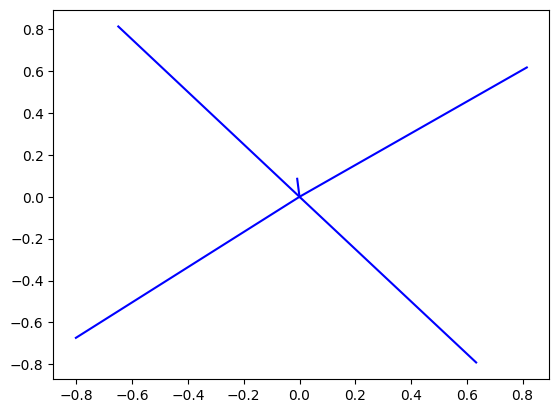

In [ ]:
en = autoencoder.W.detach().cpu().numpy()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

In [ ]:
#@title Train Eigenmodel
batch_size = 48
hessian_samples = 2
learning_rate = .1
n_epochs = 100
lambda_penalty = .1

eigen_model = EigenEstimation(5, autoencoder,  nn.MSELoss())
dataloader = DataLoader(TensorDataset(X_tms, Y_tms),
                        batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))


TrainEigenestimation(eigen_model, learning_rate, n_epochs, lambda_penalty,
                     dataloader=dataloader, criterion=nn.MSELoss(), hessian_samples=hessian_samples)


Epoch [1/100], Total total_losses: -0.016, High hessian Loss: -0.016, orthogonality Term: 0.001
Epoch [11/100], Total total_losses: -0.021, High hessian Loss: -0.021, orthogonality Term: 0.002
Epoch [21/100], Total total_losses: -0.028, High hessian Loss: -0.028, orthogonality Term: 0.002
Epoch [31/100], Total total_losses: -0.040, High hessian Loss: -0.040, orthogonality Term: 0.003
Epoch [41/100], Total total_losses: -0.046, High hessian Loss: -0.047, orthogonality Term: 0.004
Epoch [51/100], Total total_losses: -0.055, High hessian Loss: -0.056, orthogonality Term: 0.006
Epoch [61/100], Total total_losses: -0.066, High hessian Loss: -0.066, orthogonality Term: 0.007
Epoch [71/100], Total total_losses: -0.075, High hessian Loss: -0.076, orthogonality Term: 0.009
Epoch [81/100], Total total_losses: -0.092, High hessian Loss: -0.093, orthogonality Term: 0.012
Epoch [91/100], Total total_losses: -0.101, High hessian Loss: -0.102, orthogonality Term: 0.015


In [ ]:
dataloader = DataLoader(TensorDataset(X_tms[:20,], Y_tms[:20,]), batch_size=1,
                        shuffle=True, generator=torch.Generator(device='cuda'))
print(eigen_model.U.detach().cpu().numpy().round(3))
print((eigen_model.U @ eigen_model.U.transpose(0,1)).detach().cpu().numpy().round(3))
for x,_ in dataloader:
  H, _ = eigen_model((x>0).float())
  print((x>0).float(), H.detach().cpu().numpy().round(3))

[[ 0.065 -0.425  0.049 -0.051  0.031 -0.046  0.644  0.045  0.102  0.083
   0.093  0.587 -0.054  0.057  0.115]
 [ 0.054 -0.043  0.681  0.019 -0.07  -0.022  0.158  0.408 -0.112 -0.081
   0.013  0.157 -0.527 -0.028 -0.112]
 [ 0.102  0.003  0.516 -0.044 -0.007  0.133  0.007  0.618 -0.015  0.049
  -0.148 -0.027 -0.543 -0.002  0.039]
 [-0.03  -0.041  0.    -0.058 -0.623 -0.008 -0.019  0.009 -0.034 -0.475
  -0.018  0.01  -0.004  0.002 -0.615]
 [-0.138  0.117  0.077  0.38   0.042 -0.15   0.059 -0.     0.126 -0.408
   0.011 -0.734 -0.134  0.034  0.223]]
[[ 1.     0.263  0.066 -0.121 -0.445]
 [ 0.263  1.     0.88   0.158  0.005]
 [ 0.066  0.88   1.    -0.034  0.066]
 [-0.121  0.158 -0.034  1.    -0.003]
 [-0.445  0.005  0.066 -0.003  1.   ]]
tensor([[0., 0., 0., 0., 1.]], device='cuda:0') [0.031 0.044 0.003 1.969 0.028]
tensor([[1., 0., 0., 0., 0.]], device='cuda:0') [0.028 0.007 0.031 0.177 0.056]
tensor([[1., 0., 0., 0., 0.]], device='cuda:0') [0.028 0.007 0.031 0.177 0.056]
tensor([[0., 0., 1

## Polytope Model

Epoch 300, Loss: 0.005462843459099531
Epoch 400, Loss: 0.0075173145160079
Epoch 500, Loss: 0.001831928500905633
Epoch 600, Loss: 0.007628620136529207
Epoch 700, Loss: 0.008919965475797653
Epoch 800, Loss: 0.005925615318119526
Epoch 900, Loss: 0.006718121003359556


Text(0, 0.5, 'Y')

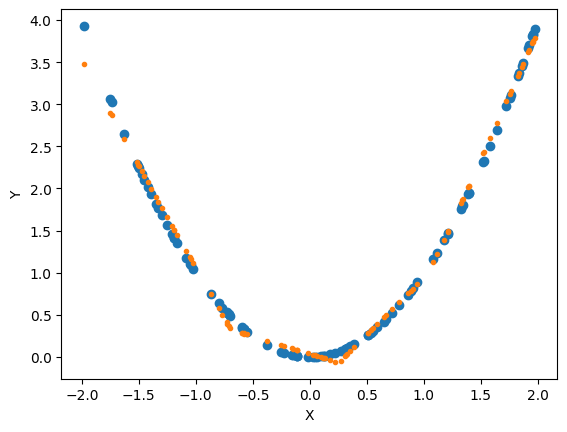

In [ ]:
#@title Train Polytope
n_datapoints = 100
X_polytope = torch.rand((n_datapoints, 1)) * 4 - 2
Y_polytope = X_polytope**2
dataloader_polytope = DataLoader(TensorDataset(X_polytope, Y_polytope), batch_size=48, shuffle=True,
                                 generator=torch.Generator(device='cuda'))

polytope_model = FeedForwardNN(1, 10, 1, 1)
_, _, _ = TrainModel(polytope_model, nn.MSELoss(), .01, dataloader_polytope, n_epochs=1000)


# Predict on X_polytope
with torch.no_grad():
    predictions = polytope_model(X_polytope).cpu()

# Plot X and predictions
plt.scatter(X_polytope.cpu().numpy(), Y_polytope.cpu().numpy(), label='Ground Truth')
plt.scatter(X_polytope.cpu().numpy(), predictions.numpy(), label='Predictions', marker='.')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
#@title Train Eigenmodel
batch_size = 48
hessian_samples = 4
learning_rate = .001
n_epochs = 1000
lambda_penalty = 1

eigen_model = EigenEstimation(4, polytope_model,  nn.MSELoss())
dataloader =  DataLoader(TensorDataset(X_polytope, Y_polytope), batch_size=batch_size, shuffle=True,
                                 generator=torch.Generator(device='cuda'))

# Train model
TrainEigenestimation(eigen_model, learning_rate, n_epochs, lambda_penalty,
                     dataloader=dataloader, criterion=nn.MSELoss(), hessian_samples=hessian_samples)



Epoch [1/1000], Total total_losses: -0.170, High hessian Loss: -0.188, orthogonality Term: 0.017
Epoch [101/1000], Total total_losses: -165.690, High hessian Loss: -165.731, orthogonality Term: 0.041
Epoch [201/1000], Total total_losses: -219.068, High hessian Loss: -220.925, orthogonality Term: 1.857
Epoch [301/1000], Total total_losses: -247.229, High hessian Loss: -248.131, orthogonality Term: 0.902
Epoch [401/1000], Total total_losses: -234.496, High hessian Loss: -235.633, orthogonality Term: 1.136
Epoch [501/1000], Total total_losses: -224.945, High hessian Loss: -227.445, orthogonality Term: 2.500
Epoch [601/1000], Total total_losses: -238.951, High hessian Loss: -240.668, orthogonality Term: 1.718
Epoch [701/1000], Total total_losses: -239.231, High hessian Loss: -243.181, orthogonality Term: 3.951
Epoch [801/1000], Total total_losses: -222.532, High hessian Loss: -224.532, orthogonality Term: 2.000
Epoch [901/1000], Total total_losses: -233.587, High hessian Loss: -235.518, or

In [ ]:
# Look up examples
X_examples = torch.linspace(-2, 2, 10)
dataloader = DataLoader(X_examples, batch_size=1,
                        shuffle=False, generator=torch.Generator(device='cuda'))

print((eigen_model.U @ eigen_model.U.transpose(0,1)).detach().cpu().numpy().round(3))
for x in dataloader:
  H, _ = eigen_model(x)
  print(x.detach().cpu().numpy().round(3), '-->', H.detach().cpu().numpy().round(3))

[[ 3.431e+00 -2.700e-02  3.000e-03  1.740e-01]
 [-2.700e-02  1.000e+00  9.300e-02  2.000e-03]
 [ 3.000e-03  9.300e-02  1.000e+00 -5.200e-02]
 [ 1.740e-01  2.000e-03 -5.200e-02  1.060e+00]]
[-2.] --> [ 0.459  0.267  0.166 75.855]
[-1.556] --> [4.1100e-01 3.3000e-02 1.2800e-01 5.3717e+01]
[-1.111] --> [6.8800e-01 4.0000e-03 1.2500e-01 3.5569e+01]
[-0.667] --> [1.607e+00 4.000e-02 8.000e-03 8.863e+00]
[-0.222] --> [3.156 0.13  0.    5.039]
[0.222] --> [5.222 0.285 0.    2.282]
[0.667] --> [20.819  0.787  0.     0.347]
[1.111] --> [3.7822e+01 3.0000e-03 5.4000e-02 8.6000e-02]
[1.556] --> [6.0097e+01 8.8000e-02 1.0000e-03 6.4000e-02]
[2.] --> [8.5546e+01 1.4300e-01 1.0000e-02 4.8000e-02]


In [ ]:
import torch

# Assume model is your pre-trained model and perturbations is a list of tensors
# containing small values to add to each parameter in the model.

# Store the original state of the model

from torch.func import functional_call

# Function to perturb weights using functional_call
def PerturbWeights(model, X_batch, perturbation_direction):
    # Get original parameters as a dictionary
    original_params = dict(model.named_parameters())

    # Create perturbed parameters
    perturbed_params = {
        name: param + perturb for (name, param), perturb in zip(original_params.items(), perturbation_direction)
    }

    # Evaluate the model with perturbed parameters
    perturbed_output = functional_call(model, perturbed_params, (X_batch,))
    return perturbed_output






class Gradient(nn.Module):
    def __init__(self, model, criterion):
        super(Gradient, self).__init__()

        self.model = model
        self.criterion = criterion
        self.eps = 1e-7
        # Copy model parameters
        # Make self.w_eps a set of parameters
        self.w_eps = [self.eps*torch.randn_like(param).requires_grad_(True) for name, param in self.model.named_parameters()]



    def forward(self, X_batch):
      output1 = PerturbWeights(self.model, X_batch, 0*self.w_eps).detach()#self.model(X_batch).detach()
      output2 = PerturbWeights(self.model, X_batch, self.w_eps)

      #L1 = self.criterion(output1, output1)
      L1 = self.criterion(output1, output1)

      L2 = self.criterion(output2, output1)
      #print(f'L2 requires_grad: {L2.requires_grad}')

      dw = torch.cat([param.flatten() for param in gradient_model.w_eps]).norm()
      dL_dw = (L2-L1) / dw


      return dL_dw

gradient_model = Gradient(zero_loss_model, nn.MSELoss())
dL_dws = []
for i,x in enumerate(X):
  grad = torch.autograd.grad(
      gradient_model(X[[i],:]),
      gradient_model.w_eps,
      retain_graph=True)
  dL_dw = torch.stack(grad).flatten()
  dL_dws.append(dL_dw)

dL_dw_tensor = torch.stack(dL_dws)
print(dL_dw_tensor)


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1377, -0.2146,  0.0892,  1.0192],
        [ 1.1534, -0.0875, -0.0572, -0.2740],
        [ 0.5157,  0.5628,  0.5847,  0.2438]], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn

# Assume zero_loss_model is your pre-trained model
model = zero_loss_model  # Replace with your actual model
criterion = nn.MSELoss()

# Ensure model parameters have requires_grad=True
for param in model.parameters():
    param.requires_grad = True

# Step 1: Compute the loss
X_batch = X[[2],:]
output = model(X_batch).detach()
loss = criterion(output, model(X_batch))

# Step 2: Compute the first derivative (gradient) w.r.t. model parameters
grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

# Step 3: Compute the second derivative (Hessian-vector product)
# To compute the full Hessian is computationally intensive; instead, compute Hessian-vector products
# For demonstration, we'll compute the Hessian with respect to a vector of ones
v = [torch.ones_like(p) for p in model.parameters()]

# Compute the dot product of gradients and vector v
grad_dot_v = sum(torch.sum(g * v_i) for g, v_i in zip(grads, v))

# Compute the second derivative (Hessian-vector product)
hessian_vec = torch.autograd.grad(grad_dot_v, model.parameters(), retain_graph=True)

# hessian_vec contains the second derivatives (Hessian-vector product)
for i, hv in enumerate(hessian_vec):
    print(f"Second derivative (Hessian-vector product) for parameter {i}:")
    print(hv)

Second derivative (Hessian-vector product) for parameter 0:
tensor([[ 2.2313,  0.0000],
        [-0.2531, -0.0000]], device='cuda:0')


In [ ]:
 gradient_model(X[[1],:])

tensor(6.8598e-08, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
gs = gradient_model(X[[2],:]).backward(inputs=gradient_model.w_eps)
[i.grad for i in gradient_model.w_eps]

[tensor([[ 1.1534, -0.0875],
         [-0.0572, -0.2740]], device='cuda:0')]

In [ ]:
torch.autograd.grad(gradient_model(x),
                      gradient_model.w_eps,
                      retain_graph=True)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
PerturbWeights(model, X_batch, perturbation_direction)

NameError: name 'X_batch' is not defined

In [ ]:
#@title Old SLT stuff
starting_params = []
ending_params = []
losses = []

for i in range(5):
  model = XORNet()
  optimizer = optim.SGD(model.parameters(), lr=0.1)
  print(f'----Model {i}----')
  model, params, loss = TrainModel(model, nn.MSELoss(), optimizer, dataloader_xornet, n_epochs=100)
  PlotTrajectories(loss, params)
  starting_params.append(params[0])
  ending_params.append(params[-1])
  losses.append(loss[-1])
  if loss[-1] < .01:
    zero_loss_model = model
    print("Zero loss model")
  if loss[-1] > .1:
    nonzero_loss_model = model
    print("Non-zero loss model")


----Model 0----


TypeError: '<' not supported between instances of 'SGD' and 'float'

In [ ]:
# Turn parameter list into vector
torch.cat([param.flatten() for param in gradient_model.w_eps]).norm()


tensor(1.1197e-06, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
# Forward pass
output = gradient_model(X[[3], :])

# Compute gradients
grad_w_eps = torch.autograd.grad(output, list(gradient_model.w_eps), create_graph=True)

# Check the gradients for each element in w_eps
for i, grad in enumerate(grad_w_eps):
    print(f'Gradient for w_eps[{i}]: {grad}')

L2 requires_grad: True
tensor(0., device='cuda:0', grad_fn=<SubBackward0>)
Gradient for w_eps[0]: tensor([[0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<TBackward0>)


## Hessian Reconstruction

In [ ]:
import torch
import torch.nn as nn

def HessianBatch(model, X, criterion):
  hessians = np.array([])
  # Compute the loss
  outputs = model(X)
  loss = criterion(outputs, outputs.detach())

  # Compute gradients w.r.t. parameters
  grads = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
  flat_grad = torch.cat([g.view(-1) for g in grads])

  # Compute the Hessian matrix
  num_params = flat_grad.shape[0]
  hessian_matrix = torch.zeros(num_params, num_params)
  for idx in range(num_params):
    grad2 = torch.autograd.grad(flat_grad[idx], model.parameters(), retain_graph=True)
    grad2_flat = torch.cat([g.contiguous().view(-1) for g in grad2])
    hessian_matrix[idx] = grad2_flat.detach()

    # Print the Hessian matrix
    #print('Sample')
    #print('gradient', flat_grad)
    #print(X_i.data, '->', Y_i.data, outputs.data, loss)

  return hessian_matrix



def Hessian(model, X, criterion):
  hessians = np.array([])
  # Compute the loss
  outputs = model(X)
  loss = criterion(outputs, outputs.detach()).sum(dim=-1)

  # Compute gradients w.r.t. parameters
  flat_params = list(model.parameters())
  numel = sum([p.numel() for p in flat_params])
  hessian = torch.zeros((len(X), numel, numel))


  for x_i, _ in enumerate(X):
    grads = torch.autograd.grad(loss[x_i], flat_params, create_graph=True)
    grads = torch.cat([g.contiguous().view(-1) for g in grads])
    for g_i, g in enumerate(grads):
      hessian[x_i, g_i, :] = torch.concat([i.flatten() for i in (torch.autograd.grad(g, flat_params, create_graph=True))])
  return hessian

class EigenEstimation(nn.Module):
    def __init__(self, n, k):
        super(EigenEstimation, self).__init__()
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(n, k))
        self.V = nn.Parameter(torch.randn(k, n))


    def forward(self, H):
        # A is of shape [batch_size, n, n]
        # Compute U^T H U for each matrix in the batch
        U = self.U  # [n, k]
        V = self.V
        # Normalize U
        #U = U / torch.norm(U, dim=1, keepdim=True)  # [n, k]
        #U_t = U.transpose(0, 1)  # [k, n]
        #U_t = U.transpose(0, 1)  # [k, n]


        # Compute M = P H U
        #UVHUV
        M = abs(torch.matmul(V.unsqueeze(0), torch.matmul(H, U.unsqueeze(0))))  # [batch_size, k, k]

        # Extract the diagonal elements of M
        diag_elements = (torch.diagonal(M, dim1=-2, dim2=-1))  # [batch_size, k]
        #print(diag_elements)

        # Create diagonal matrices D from diag_elements
        D = torch.zeros_like(M)
        indices = torch.arange(M.size(-1))
        D[:, indices, indices] = diag_elements

        # Reconstruct A
        H_reconstructed = torch.matmul(U.unsqueeze(0), torch.matmul(M, V.unsqueeze(0)))  # [batch_size, n, n]

        return H_reconstructed, diag_elements


def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = torch.mean((H - H_reconstructed) ** 2)

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = torch.mean(torch.mean(abs(diag_elements), dim=1), dim=0)  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(model, learning_rate, num_epochs, lambda_penalty, k, dataloader, criterion):
  # Hyperparameters
  n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices

  # Create model
  eigen_model = EigenEstimation(n, k)

  # Optimizer
  optimizer = torch.optim.SGD(eigen_model.parameters(), lr=learning_rate)
  eigen_model.train()

  # Training loop
  for epoch in range(num_epochs):
    total_losses = 0
    reconstruction_losses = 0
    penalty_terms = 0
    optimizer.zero_grad()
    for X_batch, Y_batch in dataloader:
      #print(f'epoch{epoch}')


      H = Hessian(model, X_batch+.0*torch.randn_like(X_batch), criterion=criterion(reduction='none'))
      # Forward pass
      H_reconstructed, diag_elements = eigen_model(H)
      #print(X_batch, H_reconstructed)

      #print(H, diag_elements, H_reconstructed, diag_elements)
      # Compute loss
      total_loss, reconstruction_loss, penalty_term = total_loss_function(
          H, H_reconstructed, diag_elements, lambda_penalty
      )
      total_losses = total_losses + total_loss
      reconstruction_losses = reconstruction_losses + reconstruction_loss
      penalty_terms = penalty_terms + penalty_term

      # Backward pass and optimization
      total_loss.backward()
      optimizer.step()

    # Print losses
    if (epoch + 1) % round(num_epochs/10) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total total_losses: {total_losses.item():.6f}, "
              f"Reconstruction Loss: {reconstruction_losses.item():.6f}, "
              f"Penalty Term: {penalty_terms.item():.6f}")
    if reconstruction_losses < .01: break

  return eigen_model



def ComputeDiagonals(model, eigenmodel, dataloader, criterion):
  diag_elements_list = []
  for X_batch, Y_batch in dataloader:
    H = Hessian(model, X_batch, criterion=nn.MSELoss(reduction='none'))

    # Forward pass
    H_reconstructed, diag_elements = eigenmodel(H)

    diag_elements_list.append(diag_elements)
    #print(X_batch)
    #print(H, H_reconstructed)
    print(X_batch , '->', diag_elements.detach().numpy().round(2))
  return torch.Tensor(torch.concat(diag_elements_list))

## Partial Hessian

In [ ]:
def PearlmutterProducts(R, L, grads_flat, params, vector):
    ### Compute y1 = V H U r1
    # Step 1: s1 = U r1
    # Step 2: Compute H s1 via Hessian-vector product
    grads_R_v = torch.dot(grads_flat, R @ vector )
    HR_v = torch.autograd.grad(grads_R_v, params, retain_graph=True)[0]  # H_s1 ∈ ℝ^{n}

    # Step 3: y1 = V H_s1
    LHR_r = L @ HR_v.flatten()  # y1 ∈ ℝ^{k}
    return LHR_r

class EigenEstimation(nn.Module):
    def __init__(self, k, model, criterion):
        super(EigenEstimation, self).__init__()

        n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(n, k))
        self.V = nn.Parameter(torch.randn(k, n))
        self.model = model
        self.criterion = criterion


    def forward(self, X_batch, orig_idxs, transformed_idxs):
        # A is of shape [batch_size, n, n]
        # Compute U^T H U for each matrix in the batch

        # Normalize columns of U
        self.U.data = self.U.data / torch.norm(self.U.data, dim=1, keepdim=True)  # [n, k]

        # Normalize columns of V
        self.V.data = self.V.data / torch.norm(self.V.data, dim=1, keepdim=True)  # [n, k]

        U = self.U  # [n, k]
        V = self.V


        model = self.model
        criterion = self.criterion
        loss = criterion(model(X_batch), model(X_batch).detach())




        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
        grads_flat = torch.cat([g.view(-1) for g in grads])
        H_rs = []
        UVHUV_rs = []
        diags = []
        for i in orig_idxs:

          r = torch.zeros(U.shape[0], device='cuda')
          r[i] = 1


          # True Hessian-vector product
          H_r = torch.autograd.grad(torch.dot(grads_flat, r), model.parameters(), retain_graph=True)[0]  # H_s1 ∈ ℝ^{n}
          H_r_flat = torch.cat([h.view(-1) for h in H_r])
          H_rs.append(H_r_flat)


          # True Hessian-vector product
          UVHUV_r = PearlmutterProducts(U@V, U@V, grads_flat, model.parameters(), r)
          UVHUV_r_flat = torch.cat([h.view(-1) for h in UVHUV_r])
          UVHUV_rs.append(UVHUV_r_flat)


        for i in transformed_idxs:

          r = torch.zeros(U.shape[1], device='cuda')
          r[i] = 1

          # Transformed Hessian-vector
          VHU_r = PearlmutterProducts(U, V, grads_flat, model.parameters(), r)
          VHU_r_flat = torch.cat([h.view(-1) for h in VHU_r])
          diags.append(VHU_r_flat[i])


        return torch.stack(H_rs), torch.stack(UVHUV_rs),  torch.stack(diags)


In [ ]:
#@ Train
def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = ((H - H_reconstructed) ** 2).mean()

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = abs(diag_elements).mean()  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(
    eigenmodel, lambda_penalty, dataloader, hessian_samples,
    learning_rate, num_epochs, n_params_per_batch, n_transformed_params_per_batch):
  # Hyperparameters

  k = eigenmodel.U.shape[1]
  n = eigenmodel.U.shape[0] # Dimension of the matrices
  # Optimizer
  optimizer = torch.optim.SGD(eigenmodel.parameters(), lr=learning_rate)
  eigenmodel.train()

  # Training loop
  for epoch in range(num_epochs):
    reconstruction_losses = 0
    penalty_terms = 0
    total_losses = 0
    n_batch = 0
    for X_superbatch, _ in dataloader:
      L = 0


      sub_dataloader = DataLoader(TensorDataset(X_superbatch), hessian_samples, shuffle=True,
                                  generator=torch.Generator(device='cuda'))

      for X_batch in sub_dataloader:
        n_batch = n_batch + 1
        orig_idxs = np.random.choice(n, n_params_per_batch, replace=False)
        transformed_idxs = np.random.choice(k, n_transformed_params_per_batch, replace=False)
        H, H_reconstructed, diag_elements = eigenmodel(X_batch[0], orig_idxs, transformed_idxs)

        # Compute loss
        total_loss, reconstruction_loss, penalty_term = total_loss_function(
            H, H_reconstructed, diag_elements, lambda_penalty
        )
        L = L + total_loss

        total_losses = total_losses + total_loss
        reconstruction_losses = reconstruction_losses + reconstruction_loss
        penalty_terms = penalty_terms + penalty_term


      # Backward pass and optimization
      L.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Print losses
    if (epoch + 1) % round(num_epochs/100) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
              f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
              f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
    if reconstruction_losses < .01:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
          f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
          f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
        break



# Differentiating model with respect to params



In [ ]:
import torch

# Assume `model` is your pre-trained model and `perturbations` is a list of tensors
# containing small values to add to each parameter in the model.

# Store the original state of the model

from torch.func import functional_call

def PerturbWeightsOld(model, X_batch, perturbation_direction):#, loss_fn=nn.MSELoss(reduction='none')):

    # Create perturbed parameters
    perturbed_params = {name: param + perturb
                        for (name, param), perturb  in zip(model.named_parameters(), perturbation_direction)}

    # Evaluate the model with perturbed parameters
    perturbed_output = functional_call(model, perturbed_params, X_batch)


    return perturbed_output


def PerturbWeights(fmodel, w0, w_eps, X_batch):
    param_dict = {name: param + perturb for (name, param), perturb in zip(model.named_parameters(), w_eps)}
    perturbed_output = functional_call(model, param_dict, X_batch)
    return perturbed_output





class Gradient(nn.Module):
    def __init__(self, model, criterion):
        super(Gradient, self).__init__()

        self.fmodel, self.fmodel_params = make_functional(model)

        self.criterion = criterion

        # Copy model parameters
        # Make self.w_eps a set of parameters
        self.w_eps = nn.ParameterList(
            [nn.Parameter(torch.zeros_like(param)) for name, param in self.model.named_parameters()]
        )

    def fmodel_forward(self, params, x):
      return self.fmodel(params, x)


    def forward(self, X_batch):
      output1 = self.model(X_batch, fmodel_params).detach()

      output2 = PerturbWeights(self.fmodel, X_batch, self.w_eps)

      #L1 = self.criterion(output1, output1)

      L2 = self.criterion(output2, output1)
      print(L2.requires_grad)  # Should output: True

      L2.backward()
      for p in self.w_eps:
          print(p.grad)  # Should not be None or zero

      dL_dw = (L2)
      return dL_dw


gradient_model = Gradient(zero_loss_model, nn.MSELoss())
#gradient_model(X).backward()

print(gradient_model(X[[3],:]))

#torch.autograd.grad(gradient_model(X[[3],:]), gradient_model.w_eps, create_graph=True)

#grad_w_eps = torch.autograd.grad(gradient_model(X[[3], :]), list(gradient_model.w_eps), create_graph=True)
#grad_w_eps

<ipython-input-122-80123a509ba5>:75: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, fmodel_params = make_functional(zero_loss_model)


ValueError: Expected all elements of parameter_and_buffer_dicts to be dictionaries

In [ ]:
# Function to perturb weights
def PerturbWeights(model, X_batch, perturbation_direction):
    # Get the original parameters
    original_params = dict(model.named_parameters())

    # Create perturbed parameters
    perturbed_params = {
        name: param + perturb
        for (name, param), perturb in zip(original_params.items(), perturbation_direction)
    }

    # Get buffers
    original_buffers = dict(model.named_buffers())

    # Combine perturbed parameters and original buffers
    params_and_buffers = {**perturbed_params, **original_buffers}

    # Evaluate the model with perturbed parameters
    perturbed_output = functional_call(model, params_and_buffers, (X_batch,))
    return perturbed_output

# Gradient model
class Gradient(nn.Module):
    def __init__(self, model, criterion):
        super(Gradient, self).__init__()
        self.model = model
        self.criterion = criterion

        # Initialize w_eps with requires_grad=True
        self.w_eps = nn.ParameterList(
            [
                nn.Parameter(torch.zeros_like(param))
                for param in self.model.parameters()
            ]
        )

    def forward(self, X_batch):
        # Detach to prevent gradients flowing back to the model's parameters
        output1 = self.model(X_batch).detach()

        # Forward pass with perturbed parameters
        output2 = PerturbWeights(self.model, X_batch, self.w_eps)

        # Compute loss
        L2 = self.criterion(output2, output1)
        return L2

# Instantiate the model and criterion
criterion = nn.MSELoss()

# Instantiate the Gradient model
gradient_model = Gradient(zero_loss_model, criterion)

# Sample input data
#X = torch.randn(4, 10)

# Forward pass
output = gradient_model(X)

# Compute gradients
grad_w_eps = torch.autograd.grad(output, list(gradient_model.w_eps), create_graph=True)
grad_w_eps
# Check the gradients
#for i, grad in enumerate(grad_w_eps):
#    print(f'Gradient for w_eps[{i}]: {grad.norm().item()}')

(tensor([[0., 0.],
         [0., 0.]], device='cuda:0', grad_fn=<TBackward0>),)

In [ ]:
def PerturbWeights(fmodel, w0, w_eps, X_batch):
    param_dict = {name: param + perturb for (name, param), perturb in zip(w0, w_eps)}
    #print
    perturbed_output = functional_call(fmodel, w0, X_batch)

#    perturbed_output = functional_call(model, param_dict, X_batch)
    return perturbed_output

fmodel, fmodel_params = make_functional(zero_loss_model)

PerturbWeights(fmodel, fmodel_params, fmodel_params, X[[1],:])


<ipython-input-124-1162606811d4>:9: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, fmodel_params = make_functional(zero_loss_model)


ValueError: Expected all elements of parameter_and_buffer_dicts to be dictionaries

In [ ]:
fmodel_params

(Parameter containing:
 tensor([[-0.7024,  1.1023],
         [ 1.2751, -1.8069]], device='cuda:0', requires_grad=True),)

(Parameter containing:
 tensor([[-0.7024,  1.1023],
         [ 1.2751, -1.8069]], device='cuda:0', requires_grad=True),)

In [ ]:
from torch.func import make_functional
from torch.func import make_functional

fmodel, params = make_functional(model)

def fmodel_forward(params, x):
    return fmodel(params, x)

Parameter containing:
tensor([[0., 0.],
        [0., 0.]], device='cuda:0', requires_grad=True)


In [ ]:
a = PerturbWeights(zero_loss_model, X, nn.ParameterList(
            [.000000*torch.rand_like(param) for name, param in zero_loss_model.named_parameters()]
            )).sum()


In [ ]:


#PerturbWeights(gradient_model, X, gradient_model.w_eps)


tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)


(tensor([[0., 0.],
         [0., 0.]], device='cuda:0', grad_fn=<TBackward0>),)

In [ ]:
gradient_model(X)

tensor(0., device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
#for i in gradient_model.named_parameters(): print(i)

# Compute the gradient of gradient_model with respect to w_eps using autograd


(tensor([[0., 0.],
         [0., 0.]], device='cuda:0'),)

# Adding Vector to Weights



In [ ]:
import torch

# Assume `model` is your pre-trained model and `perturbations` is a list of tensors
# containing small values to add to each parameter in the model.

# Store the original state of the model

from torch.func import functional_call

def PerturbWeights(model, X, perturbation_direction, eps=1e-5, loss_fn=nn.MSELoss(reduction='none')):
    # Get the original outputs
    orig_output = model(X)  # `X` is your input tensor

    # Create perturbed parameters
    perturbed_params = {name: param + eps * perturb
                        for (name, param), perturb in zip(model.named_parameters(), perturbation_direction)}

    # Evaluate the model with perturbed parameters
    perturbed_output = functional_call(model, perturbed_params, X)

    # Compute the loss
    loss_value = loss_fn(perturbed_output, orig_output) / (eps**2)

    return loss_value




class PerturbationEstimation(nn.Module):
    def __init__(self, model, k, criterion, eps=1e-6):
        super(PerturbationEstimation, self).__init__()

        self.model = model
        self.eps = eps
        self.criterion = criterion

        # Initialize U as a list of k directions
        self.U = nn.ModuleList()
        for _ in range(k):
            # For each direction, create a nn.ParameterList of parameters matching the model's parameters
            u_direction = nn.ParameterList()
            for param in model.parameters():
                u_param = nn.Parameter(torch.randn_like(param))
                u_direction.append(u_param)
            self.U.append(u_direction)


        # Initialize U with Xavier initialization and normalize
        for u_direction in self.U:
            for u_param in u_direction:
                nn.init.xavier_normal_(u_param)
                u_param.data /= u_param.data.norm() + 1e-8  # Normalize to prevent division by zero



    def forward(self, X_batch):

        # Initialize U with Xavier initialization and normalize
        for u_direction in self.U:
            for u_param in u_direction:
                u_param.data /= u_param.data.norm() + 1e-8  # Normalize to prevent division by zero



        U = self.U  # [n, k]



        gradients = []
        for u in U:
          gradient = PerturbWeights(self.model,X_batch, u, eps=1e-6)
          gradients.append(gradient.flatten())


        gradient_stack = torch.stack(gradients)
        # Noramlize each row of gradient stack
        gradient_stack = gradient_stack #/ (gradient_stack.sum(dim=0,keepdim=True) + 1e-10)
        return gradient_stack




def TrainPerturbationEstimation(
    perturb_model, lambda_penalty, dataloader,
    learning_rate, num_epochs):

    # Collect all parameters from U
    all_params = [p for u_direction in perturb_model.U for p in u_direction]

    optimizer = torch.optim.Adam(all_params, lr=learning_rate)
    perturb_model.train()

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        total_high_hessian_loss = 0
        total_sparsity_loss = 0
        n_batches = 0

        for X_batch, _ in dataloader:
            optimizer.zero_grad()
            k_mat = perturb_model(X_batch)
            high_hessian_loss = (k_mat**2).var()
            sparsity_loss =  abs(all_params @ all_params.transpose(0,1)).sum()
            L = (-1 * high_hessian_loss) + (lambda_penalty * sparsity_loss)

            L.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += L.item()
            total_high_hessian_loss += high_hessian_loss.item()
            total_sparsity_loss += sparsity_loss.item()
            n_batches += 1



        # Print losses
        if (epoch + 1) % max(round(num_epochs/10), 1) == 0 or epoch == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Total Loss: {total_loss/n_batches:.4f}, "
                  f"L2 loss: {total_high_hessian_loss/n_batches:.4f}, "
                  f"L1: {total_sparsity_loss/n_batches:.4f}")



In [ ]:
perturb_model = PerturbationEstimation(zero_loss_model, 5, nn.MSELoss())
dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)),
                        batch_size=4, shuffle=True, generator=torch.Generator(device='cuda'))

TrainPerturbationEstimation(perturb_model, .2, dataloader, learning_rate=.001, num_epochs=1000)


AttributeError: 'ModuleList' object has no attribute 'transpose'

In [ ]:
for x_, y_ in DataLoader(
    TensorDataset(X, Y),
    batch_size=4, shuffle=False, generator=torch.Generator(device='cuda')):
    print(x_, '->')
    print(perturb_model(x_).transpose(0,1))


tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], device='cuda:0') ->
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5116, 0.5116, 0.3553, 0.3553, 0.5116],
        [0.2274, 0.5116, 0.3553, 0.1279, 0.0888],
        [0.7729, 0.9381, 0.0000, 0.8535, 0.6004]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [ ]:



#@ Train
def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = ((H - H_reconstructed) ** 2).mean()

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = abs(diag_elements).mean()  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(
    eigenmodel, lambda_penalty, dataloader, hessian_samples,
    learning_rate, num_epochs):
  # Hyperparameters

  k = eigenmodel.U.shape[1]
  n = eigenmodel.U.shape[0] # Dimension of the matrices
  # Optimizer
  optimizer = torch.optim.SGD(eigenmodel.parameters(), lr=learning_rate)
  eigenmodel.train()

  # Training loop
  for epoch in range(num_epochs):
    reconstruction_losses = 0
    penalty_terms = 0
    total_losses = 0
    n_batch = 0
    for X_superbatch, _ in dataloader:
      L = 0

      sub_dataloader = DataLoader(TensorDataset(X_superbatch), hessian_samples, shuffle=True,
                                  generator=torch.Generator(device='cuda'))

      for X_batch in sub_dataloader:
        n_batch = n_batch + 1
        H, H_reconstructed, diag_elements = eigenmodel(X_batch[0])# + .01 * torch.randn_like(X_batch[0]))

        # Compute loss
        total_loss, reconstruction_loss, penalty_term = total_loss_function(
            H, H_reconstructed, diag_elements, lambda_penalty
        )
        L = L + total_loss

        total_losses = total_losses + total_loss
        reconstruction_losses = reconstruction_losses + reconstruction_loss
        penalty_terms = penalty_terms + penalty_term


      # Backward pass and optimization
      L.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Print losses
    if (epoch + 1) % round(num_epochs/100) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
              f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
              f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
    if reconstruction_losses < .01:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
          f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
          f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
        break





In [ ]:
#@title Model

class EigenEstimation(nn.Module):
    def __init__(self, k, model, criterion, eps=1e-5):
        super(EigenEstimation, self).__init__()

        n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(n, k))

        # Initialize self.U with xavier
        nn.init.xavier_normal_(self.U)

        self.model = model
        self.criterion = criterion


    def forward(self, X_batch):
        # A is of shape [batch_size, n, n]
        # Compute U^T H U for each matrix in the batch

        # Normalize columns of U
        #self.U.data = self.U.data / torch.norm(self.U.data, dim=1, keepdim=True)  # [n, k]

        # Normalize columns of V
        #self.V.data = self.V.data / torch.norm(self.V.data, dim=1, keepdim=True)  # [n, k]

        U = self.U  # [n, k]
        # Add model




        model = self.model
        criterion = self.criterion
        loss = criterion(model(X_batch), model(X_batch).detach())

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grads_flat = torch.cat([g.view(-1) for grad in grads for g in grad])

        H_list = []
        # True Hessian-vector product
        for g in grads_flat:
          H_i = torch.autograd.grad(g, model.parameters(), retain_graph=True)  # H_s1 ∈ ℝ^{n}
          H_i_flat = torch.cat([h.view(-1) for hh in H_i for h in hh])
          H_list.append(H_i_flat)
        H = torch.stack(H_list)

        # Transformed Hessian
        UHU = abs(U.transpose(0,1) @ H @ U)

        # Get diagonal elements of VHU
        diag_UHU = torch.diagonal(UHU)


        H_r = V.transpose(0,1) @ UHU @ V

        return H, H_r, torch.diagonal(UHU)





#@ Train
def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = ((H - H_reconstructed) ** 2).mean()

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = abs(diag_elements).mean()  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(
    eigenmodel, lambda_penalty, dataloader, hessian_samples,
    learning_rate, num_epochs):
  # Hyperparameters

  k = eigenmodel.U.shape[1]
  n = eigenmodel.U.shape[0] # Dimension of the matrices
  # Optimizer
  optimizer = torch.optim.SGD(eigenmodel.parameters(), lr=learning_rate)
  eigenmodel.train()

  # Training loop
  for epoch in range(num_epochs):
    reconstruction_losses = 0
    penalty_terms = 0
    total_losses = 0
    n_batch = 0
    for X_superbatch, _ in dataloader:
      L = 0

      sub_dataloader = DataLoader(TensorDataset(X_superbatch), hessian_samples, shuffle=True,
                                  generator=torch.Generator(device='cuda'))

      for X_batch in sub_dataloader:
        n_batch = n_batch + 1
        H, H_reconstructed, diag_elements = eigenmodel(X_batch[0])# + .01 * torch.randn_like(X_batch[0]))

        # Compute loss
        total_loss, reconstruction_loss, penalty_term = total_loss_function(
            H, H_reconstructed, diag_elements, lambda_penalty
        )
        L = L + total_loss

        total_losses = total_losses + total_loss
        reconstruction_losses = reconstruction_losses + reconstruction_loss
        penalty_terms = penalty_terms + penalty_term


      # Backward pass and optimization
      L.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Print losses
    if (epoch + 1) % round(num_epochs/100) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
              f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
              f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
    if reconstruction_losses < .01:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
          f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
          f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
        break



# Full Hessian

In [ ]:
#@title Model

class EigenEstimation(nn.Module):
    def __init__(self, k, model, criterion):
        super(EigenEstimation, self).__init__()

        n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices

        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(n, k))
        self.V = nn.Parameter(torch.randn(k, n))

        # Initialize self.U with xavier
        nn.init.xavier_normal_(self.U)
        nn.init.xavier_normal_(self.V)

        self.model = model
        self.criterion = criterion


    def forward(self, X_batch):
        # A is of shape [batch_size, n, n]
        # Compute U^T H U for each matrix in the batch

        # Normalize columns of U
        #self.U.data = self.U.data / torch.norm(self.U.data, dim=1, keepdim=True)  # [n, k]

        # Normalize columns of V
        #self.V.data = self.V.data / torch.norm(self.V.data, dim=1, keepdim=True)  # [n, k]

        U = self.U  # [n, k]
        V = self.V #.transpose(0,1)


        model = self.model
        criterion = self.criterion
        loss = criterion(model(X_batch), model(X_batch).detach())

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grads_flat = torch.cat([g.view(-1) for grad in grads for g in grad])

        H_list = []
        # True Hessian-vector product
        for g in grads_flat:
          H_i = torch.autograd.grad(g, model.parameters(), retain_graph=True)  # H_s1 ∈ ℝ^{n}
          H_i_flat = torch.cat([h.view(-1) for hh in H_i for h in hh])
          H_list.append(H_i_flat)
        H = torch.stack(H_list)

        # Transformed Hessian
        UHU = abs(U.transpose(0,1) @ H @ U)

        # Get diagonal elements of VHU
        diag_UHU = torch.diagonal(UHU)


        H_r = V.transpose(0,1) @ UHU @ V

        return H, H_r, torch.diagonal(UHU)





#@ Train
def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = ((H - H_reconstructed) ** 2).mean()

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = abs(diag_elements).mean()  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(
    eigenmodel, lambda_penalty, dataloader, hessian_samples,
    learning_rate, num_epochs):
  # Hyperparameters

  k = eigenmodel.U.shape[1]
  n = eigenmodel.U.shape[0] # Dimension of the matrices
  # Optimizer
  optimizer = torch.optim.SGD(eigenmodel.parameters(), lr=learning_rate)
  eigenmodel.train()

  # Training loop
  for epoch in range(num_epochs):
    reconstruction_losses = 0
    penalty_terms = 0
    total_losses = 0
    n_batch = 0
    for X_superbatch, _ in dataloader:
      L = 0

      sub_dataloader = DataLoader(TensorDataset(X_superbatch), hessian_samples, shuffle=True,
                                  generator=torch.Generator(device='cuda'))

      for X_batch in sub_dataloader:
        n_batch = n_batch + 1
        H, H_reconstructed, diag_elements = eigenmodel(X_batch[0])# + .01 * torch.randn_like(X_batch[0]))

        # Compute loss
        total_loss, reconstruction_loss, penalty_term = total_loss_function(
            H, H_reconstructed, diag_elements, lambda_penalty
        )
        L = L + total_loss

        total_losses = total_losses + total_loss
        reconstruction_losses = reconstruction_losses + reconstruction_loss
        penalty_terms = penalty_terms + penalty_term


      # Backward pass and optimization
      L.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Print losses
    if (epoch + 1) % round(num_epochs/100) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
              f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
              f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
    if reconstruction_losses < .0001:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total mean total_loss: {total_losses.item()/n_batch:.2f}, "
          f"Reconstruction Loss: {reconstruction_losses.item()/n_batch:.2f}, "
          f"Penalty Term: {penalty_terms.item()/n_batch:.2f}")
        break



## Some tests

In [ ]:
#@title Same numnber of parameters, 0 sparsity.
eigenmodel = EigenEstimation(4, zero_loss_model, nn.MSELoss())
dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)),
                        batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))
TrainEigenestimation(
    eigenmodel, dataloader=dataloader, hessian_samples = 4,
    lambda_penalty=0, learning_rate=.01, num_epochs=1000)


Epoch [1/1000], Total mean total_loss: 0.13, Reconstruction Loss: 0.13, Penalty Term: 0.42
Epoch [10/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.08, Penalty Term: 0.37
Epoch [20/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.08, Penalty Term: 0.36
Epoch [30/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.35
Epoch [40/1000], Total mean total_loss: 0.07, Reconstruction Loss: 0.07, Penalty Term: 0.35
Epoch [50/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.08, Penalty Term: 0.35
Epoch [60/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.08, Penalty Term: 0.35
Epoch [70/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.08, Penalty Term: 0.35
Epoch [80/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.36
Epoch [90/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.36
Epoch [100/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty

In [ ]:
print(eigenmodel.U, eigenmodel.V)

for X_batch, _ in DataLoader(TensorDataset(X, Y),
           batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
  print('-----', '\nsample', X_batch.cpu().numpy())
  H, H_r, diag = eigenmodel(X_batch)
  print('loss', total_loss_function(H, H_r, diag, lambda_penalty=.1))
  print(H.cpu().detach().numpy().round(2))

  print(H_r.cpu().detach().numpy().round(2))
  print(diag.cpu().detach().numpy().round(2))

Parameter containing:
tensor([[ 0.3054,  0.9218, -0.6874, -0.2352],
        [ 0.4070, -0.5366, -0.6183, -0.9631],
        [-0.0799,  0.2264, -0.0362, -0.2087],
        [-0.8878, -0.4217,  0.2710,  0.5448]], device='cuda:0',
       requires_grad=True) Parameter containing:
tensor([[ 0.5296,  0.1321,  0.6968, -0.6676],
        [-0.7195,  0.7839, -0.0750,  0.5463],
        [-0.7789, -1.1151,  0.2912, -0.1511],
        [ 0.0551,  0.0878, -1.1217, -0.8270]], device='cuda:0',
       requires_grad=True)
----- 
sample [[1. 1.]]
loss (tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3674, device='cuda:0', grad_fn=<MeanBackward0>))
[[0.67 0.67 0.52 0.52]
 [0.67 0.67 0.52 0.52]
 [0.52 0.52 0.4  0.4 ]
 [0.52 0.52 0.4  0.4 ]]
[[0.63 0.64 0.46 0.55]
 [0.64 0.65 0.47 0.55]
 [0.46 0.47 0.34 0.4 ]
 [0.55 0.55 0.4  0.48]]
[0.   0.04 0.84 0.59]
----- 
sample [[0. 0.]]
loss (tensor(0., device='cuda:0', grad_fn=<AddBackward0>), tens

In [ ]:
#@title 3 parameters (rank of H), 0 sparsity.
eigenmodel = EigenEstimation(3, zero_loss_model, nn.MSELoss())
dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)),
                        batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))
TrainEigenestimation(
    eigenmodel, dataloader=dataloader, hessian_samples = 4,
    lambda_penalty=0, learning_rate=.01, num_epochs=1000)


Epoch [1/1000], Total mean total_loss: 0.16, Reconstruction Loss: 0.16, Penalty Term: 0.63
Epoch [10/1000], Total mean total_loss: 0.07, Reconstruction Loss: 0.07, Penalty Term: 0.58
Epoch [20/1000], Total mean total_loss: 0.07, Reconstruction Loss: 0.07, Penalty Term: 0.58
Epoch [30/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.58
Epoch [40/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.58
Epoch [50/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.58
Epoch [60/1000], Total mean total_loss: 0.07, Reconstruction Loss: 0.07, Penalty Term: 0.58
Epoch [70/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.58
Epoch [80/1000], Total mean total_loss: 0.06, Reconstruction Loss: 0.06, Penalty Term: 0.58
Epoch [90/1000], Total mean total_loss: 0.05, Reconstruction Loss: 0.05, Penalty Term: 0.58
Epoch [100/1000], Total mean total_loss: 0.05, Reconstruction Loss: 0.05, Penalty

KeyboardInterrupt: 

In [ ]:
print(eigenmodel.U, eigenmodel.V)

for X_batch, _ in DataLoader(TensorDataset(X, Y),
           batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
  print('-----', '\nsample', X_batch.cpu().numpy())
  H, H_r, diag = eigenmodel(X_batch)
  print('loss', total_loss_function(H, H_r, diag, lambda_penalty=.1))
  print(H.cpu().detach().numpy().round(2))

  print(H_r.cpu().detach().numpy().round(2))
  print(diag.cpu().detach().numpy().round(2))

Parameter containing:
tensor([[-0.9134,  0.2151,  0.9125],
        [-1.2489,  0.0213,  0.5229],
        [ 0.2781,  0.2804, -0.7165],
        [-0.1143,  0.6276,  0.4683]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([[-0.3400, -0.2996, -0.7191,  0.3661],
        [ 0.5058, -0.0479, -0.6262, -1.5563],
        [-0.7321,  0.1143,  0.9512, -0.0541]], device='cuda:0',
       requires_grad=True)
----- 
sample [[1. 1.]]
loss (tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0451, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.4659, device='cuda:0', grad_fn=<MeanBackward0>))
[[0.67 0.67 0.52 0.52]
 [0.67 0.67 0.52 0.52]
 [0.52 0.52 0.4  0.4 ]
 [0.52 0.52 0.4  0.4 ]]
[[0.85 0.39 0.66 0.59]
 [0.39 0.18 0.3  0.27]
 [0.66 0.3  0.51 0.46]
 [0.59 0.27 0.46 0.42]]
[2.77 0.59 1.03]
----- 
sample [[0. 0.]]
loss (tensor(0., device='cuda:0', grad_fn=<AddBackward0>), tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), tensor(0., device='cuda:0', grad_fn=<MeanBac

In [ ]:
#@title 3 parameters (rank of H), .1 sparsity.
eigenmodel = EigenEstimation(3, zero_loss_model, nn.MSELoss())
dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)),
                        batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))
TrainEigenestimation(
    eigenmodel, dataloader=dataloader, hessian_samples = 4,
    lambda_penalty=.01, learning_rate=.001, num_epochs=1000)


Epoch [1/1000], Total mean total_loss: 0.22, Reconstruction Loss: 0.22, Penalty Term: 0.57
Epoch [10/1000], Total mean total_loss: 0.15, Reconstruction Loss: 0.14, Penalty Term: 0.54
Epoch [20/1000], Total mean total_loss: 0.16, Reconstruction Loss: 0.15, Penalty Term: 0.52
Epoch [30/1000], Total mean total_loss: 0.12, Reconstruction Loss: 0.12, Penalty Term: 0.51
Epoch [40/1000], Total mean total_loss: 0.14, Reconstruction Loss: 0.13, Penalty Term: 0.49
Epoch [50/1000], Total mean total_loss: 0.12, Reconstruction Loss: 0.12, Penalty Term: 0.49
Epoch [60/1000], Total mean total_loss: 0.15, Reconstruction Loss: 0.14, Penalty Term: 0.48
Epoch [70/1000], Total mean total_loss: 0.13, Reconstruction Loss: 0.12, Penalty Term: 0.47
Epoch [80/1000], Total mean total_loss: 0.12, Reconstruction Loss: 0.12, Penalty Term: 0.47
Epoch [90/1000], Total mean total_loss: 0.11, Reconstruction Loss: 0.11, Penalty Term: 0.47
Epoch [100/1000], Total mean total_loss: 0.11, Reconstruction Loss: 0.10, Penalty

KeyboardInterrupt: 

In [ ]:
print(eigenmodel.U, eigenmodel.V)

for X_batch, _ in DataLoader(TensorDataset(X, Y),
           batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
  print('-----', '\nsample', X_batch.cpu().numpy())
  H, H_r, diag = eigenmodel(X_batch)
  print(H.cpu().detach().numpy().round(2))

  print(H_r.cpu().detach().numpy().round(2))
  print(diag.cpu().detach().numpy().round(2))

Parameter containing:
tensor([[-0.0540,  0.4627,  0.7007],
        [-0.3748,  0.0718, -0.1068],
        [ 0.1991, -0.1161,  0.5900],
        [-1.0060, -0.0070, -0.3055]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([[-0.6125, -0.0417,  0.2098,  0.0033],
        [-0.3033, -0.5102, -0.0684,  0.5683],
        [ 1.1168,  0.9540,  0.1320,  0.3752]], device='cuda:0',
       requires_grad=True)
----- 
sample [[1. 1.]]
[[0.67 0.67 0.52 0.52]
 [0.67 0.67 0.52 0.52]
 [0.52 0.52 0.4  0.4 ]
 [0.52 0.52 0.4  0.4 ]]
[[0.01 0.04 0.03 0.05]
 [0.04 0.17 0.1  0.19]
 [0.03 0.1  0.06 0.11]
 [0.05 0.19 0.11 0.21]]
[0.75 0.13 0.44]
----- 
sample [[0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[0. 0. 0.]
----- 
sample [[1. 0.]]
[[ 2.52  0.   -0.29 -0.  ]
 [ 0.    0.    0.    0.  ]
 [-0.29 -0.    0.03  0.  ]
 [ 0.    0.    0.    0.  ]]
[[0.67 0.47 0.09 0.66]
 [0.47 0.32 0.06 0.46]
 [0.09 0.06 0.01 0.09]
 

## TMS

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder: reduces dimensionality
        self.encoder = nn.Linear(num_features, hidden_dim, bias=False)
        # Decoder: reconstructs the input
        self.decoder = nn.Linear(hidden_dim, num_features, bias=False)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


def TrainTMS(model, criterion, optimizer, dataloader, n_epochs):
  for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / num_data_points
    if epoch %10 == 0:
      print(f'Epoch [{epoch}/], Loss: {avg_loss:.4f}')


In [ ]:
#@title Model
# Data parameters
num_features = 5       # Number of unique features
feature_sparsity = 0.1    # Proportion of non-zero elements in each feature vector
num_data_points = 10000   # Total number of data points

# Model parameters
hidden_dim = 2           # Dimension of the hidden layer (bottleneck)
learning_rate = 1e-3
num_epochs = 200
batch_size = 128


# Initialize feature vectors
feature_vectors = np.random.randn(num_data_points, num_features)
feature_vectors = feature_vectors * (np.random.randn(num_data_points, num_features) < feature_sparsity)


# Convert to numpy arrays
data_inputs = np.array(feature_vectors)
data_labels = np.array(feature_vectors)


autoencoder = Autoencoder(num_features, hidden_dim)

X = torch.Tensor(data_inputs).to('cuda')
Y = torch.Tensor(data_labels).to('cuda')

dataloader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
TrainTMS(autoencoder, nn.MSELoss(), optimizer, dataloader, n_epochs=20)



Epoch [0/], Loss: 0.5375
Epoch [10/], Loss: 0.3266
Epoch [20/], Loss: 0.3260
Epoch [30/], Loss: 0.3253
Epoch [40/], Loss: 0.3248
Epoch [50/], Loss: 0.3242
Epoch [60/], Loss: 0.3235
Epoch [70/], Loss: 0.3226
Epoch [80/], Loss: 0.3217
Epoch [90/], Loss: 0.3210
Epoch [100/], Loss: 0.3205
Epoch [110/], Loss: 0.3202
Epoch [120/], Loss: 0.3200
Epoch [130/], Loss: 0.3200
Epoch [140/], Loss: 0.3199
Epoch [150/], Loss: 0.3199
Epoch [160/], Loss: 0.3199


KeyboardInterrupt: 

In [ ]:
eigen_model = EigenEstimation(5, autoencoder,  nn.MSELoss())
dataloader = DataLoader(TensorDataset(X, Y), batch_size=2, shuffle=True, generator=torch.Generator(device='cuda'))
TrainEigenestimation(eigen_model, .001, 1000, 1,  dataloader=dataloader, criterion=nn.MSELoss())

#eigen_model = EigenEstimation(k, zero_loss_model, criterion)
dataloader = DataLoader(TensorDataset(X, Y),
                        batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))
print(eigen_model.U)
for x,_ in dataloader:
  H, _ = eigen_model(x)
  print(x, H)

RuntimeError: inconsistent tensor size, expected tensor [10] and src [20] to have the same number of elements, but got 10 and 20 elements respectively

In [ ]:
#@title 5 parameters (rank of H), .01 sparsity.
eigenmodel = EigenEstimation(5, autoencoder, nn.MSELoss())
dataloader = DataLoader(TensorDataset(X, Y),
                        batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))

TrainEigenestimation(
    eigenmodel, dataloader=dataloader, hessian_samples = 4,
    lambda_penalty=.1, learning_rate=.01, num_epochs=1000)

for X_batch, _ in DataLoader(TensorDataset(X[:10], Y[:10]),
           batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
    print(X_batch, eigenmodel(X_batch)[0])


Epoch [1/1000], Total mean total_loss: 0.08, Reconstruction Loss: 0.04, Penalty Term: 0.40
Epoch [10/1000], Total mean total_loss: 0.03, Reconstruction Loss: 0.02, Penalty Term: 0.15


KeyboardInterrupt: 

In [ ]:
print(eigenmodel.U, eigenmodel.V)

for X_batch, _ in DataLoader(TensorDataset(X[:10], Y[:10]),
           batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
  print('-----', '\nsample', X_batch.cpu().numpy().round(2))
  H, H_r, diag = eigenmodel(X_batch)
  #print(H.cpu().detach().numpy().round(2))

  #print(H_r.cpu().detach().numpy().round(2))
  print(diag.cpu().detach().numpy().round(2))

Parameter containing:
tensor([[ 0.3730, -0.1318,  0.1710,  0.0796,  0.0595],
        [ 0.1385, -0.1128, -0.0637, -0.3266,  0.2329],
        [-0.0276,  0.2294,  0.1672, -0.0011,  0.3512],
        [ 0.2205,  0.0445,  0.0323, -0.1483,  0.0417],
        [-0.0623,  0.1128, -0.1724,  0.0544, -0.3555],
        [-0.2653,  0.0354, -0.1947,  0.1489, -0.1757],
        [-0.1417, -0.1948, -0.4158, -0.3539,  0.3050],
        [-0.2612, -0.2383,  0.3923, -0.1724, -0.4092],
        [-0.1710, -0.0538,  0.0740,  0.3083, -0.2742],
        [ 0.0908,  0.0367,  0.0853,  0.0757,  0.0159],
        [-0.1792, -0.1689, -0.4134, -0.0027, -0.3678],
        [ 0.0095,  0.1218, -0.2800,  0.1017, -0.0273],
        [-0.1683,  0.0312,  0.0566,  0.0946, -0.2122],
        [-0.3407, -0.0411, -0.1251,  0.0422, -0.1775],
        [ 0.4106,  0.0290,  0.1725,  0.2702, -0.0504],
        [ 0.1868,  0.3221,  0.0051,  0.1976, -0.0613],
        [-0.5837,  0.0959, -0.0047,  0.3979,  0.0273],
        [-0.1923,  0.1820, -0.4635,  0.3667

In [ ]:
zero_loss_model(X[:2,])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x5 and 2x2)

In [ ]:
import torch

# Assume model is your neural network and loss_fn is your loss function
# Forward pass
outputs1 = zero_loss_model(X[:2,]).detach()
outputs2 = zero_loss_model(X[:2,])
loss = criterion(outputs1, outputs2)


# Step 1: Compute the gradient of the loss w.r.t. model parameters
# This will compute the first-order derivatives
first_order_grads = torch.autograd.grad(loss, zero_loss_model.parameters(), create_graph=True)


# Flatten the gradients and parameters into vectors
flat_grads = torch.cat([g.view(-1) for g in first_order_grads])

# Step 2: Define a direction in parameter space (vector v)
# You can set v to a random vector or a specific direction
# Here, we use a random vector of the same size as the flattened gradient
for i in range(2000):
  v = torch.randn_like(flat_grads)

  # Step 3: Compute the dot product of the gradient and the direction vector
  grad_dot_v = torch.sum(flat_grads * v)

  # Step 4: Compute the Hessian-vector product (second-order derivative)
  hessian_vec = torch.autograd.grad(grad_dot_v, zero_loss_model.parameters(), retain_graph=True)

  # Flatten the Hessian-vector product to make it easier to analyze
  flat_hessian_vec = v @ torch.cat([hv.view(-1) for hv in hessian_vec])

  # The variable `flat_hessian_vec` now contains the second derivative in the direction of `v`
  print(flat_hessian_vec)

tensor(0.2127, device='cuda:0')
tensor(2.2856, device='cuda:0')
tensor(2.8269, device='cuda:0')
tensor(3.7592, device='cuda:0')
tensor(0.0999, device='cuda:0')
tensor(0.4014, device='cuda:0')
tensor(1.1250, device='cuda:0')
tensor(0.4729, device='cuda:0')
tensor(0.1261, device='cuda:0')
tensor(0.0224, device='cuda:0')
tensor(0.2870, device='cuda:0')
tensor(0.3234, device='cuda:0')
tensor(1.8133, device='cuda:0')
tensor(0.9049, device='cuda:0')
tensor(0.1137, device='cuda:0')
tensor(3.5765, device='cuda:0')
tensor(0.2678, device='cuda:0')
tensor(1.0457, device='cuda:0')
tensor(1.7362, device='cuda:0')
tensor(0.0444, device='cuda:0')
tensor(3.7711, device='cuda:0')
tensor(0.4289, device='cuda:0')
tensor(0.0126, device='cuda:0')
tensor(0.0443, device='cuda:0')
tensor(1.6539, device='cuda:0')
tensor(8.0503, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(3.4968, device='cuda:0')
tensor(2.5120, device='cuda:0')
tensor(0.0116, device='cuda:0')
tensor(0.0202, device='cuda:0')
tensor(0

In [ ]:
#@title partial hessian

# Step 2: Compute the gradient of the loss w.r.t. the model's parameters
grads = torch.autograd.grad(loss, zero_loss_model.parameters(), create_graph=True)

# Flatten the gradients
grads_flat = torch.cat([g.view(-1) for g in grads])

# Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
Hv = torch.autograd.grad(grads_flat @ v, zero_loss_model.parameters(), retain_graph=True)

# Flatten the Hessian-vector product
Hv_flat = torch.cat([h.view(-1) for h in Hv])

# Step 4: Compute the second-order directional derivative
second_order_derivative = (v * Hv_flat).sum()



def HessianBatch(model, X, criterion):
  hessians = np.array([])
  # Compute the loss
  outputs = model(X)
  loss = criterion(outputs, outputs.detach())

  # Compute gradients w.r.t. parameters
  grads = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
  flat_grad = torch.cat([g.view(-1) for g in grads])

  # Compute the Hessian matrix
  num_params = flat_grad.shape[0]
  hessian_matrix = torch.zeros(num_params, num_params)
  for idx in range(num_params):
    grad2 = torch.autograd.grad(flat_grad[idx], model.parameters(), retain_graph=True)
    grad2_flat = torch.cat([g.contiguous().view(-1) for g in grad2])
    hessian_matrix[idx] = grad2_flat.detach()

    # Print the Hessian matrix
    #print('Sample')
    #print('gradient', flat_grad)
    #print(X_i.data, '->', Y_i.data, outputs.data, loss)

  return hessian_matrix



def Hessian(model, X, criterion):
  hessians = np.array([])
  # Compute the loss
  outputs = model(X)
  loss = criterion(outputs, outputs.detach()).sum(dim=-1)

  # Compute gradients w.r.t. parameters
  flat_params = list(model.parameters())
  numel = sum([p.numel() for p in flat_params])
  hessian = torch.zeros((len(X), numel, numel))


  for x_i, _ in enumerate(X):
    grads = torch.autograd.grad(loss[x_i], flat_params, create_graph=True)
    grads = torch.cat([g.contiguous().view(-1) for g in grads])
    for g_i, g in enumerate(grads):
      hessian[x_i, g_i, :] = torch.concat([i.flatten() for i in (torch.autograd.grad(g, flat_params, create_graph=True))])
  return hessian

class EigenEstimation(nn.Module):
    def __init__(self, n, k, model):
        super(EigenEstimation, self).__init__()
        # Initialize U as a learnable parameter
        self.U = nn.Parameter(torch.randn(n, k))
        self.V = nn.Parameter(torch.randn(k, n))
        self.model = model


    def forward(self, idxs):
        # A is of shape [batch_size, n, n]
        # Compute U^T H U for each matrix in the batch
        U = self.U  # [n, k]
        V = self.V
        model = self.model


        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grads_flat = torch.cat([g.view(-1) for g in grads])


        H_rs = torch.Tensor([])
        UVHUV_rs = torch.Tensor([])
        diags = torch.Tensor([])
        for i in idxs:
          r = torch.zeros(U.shape[0])
          r[i] = 0

          # True Hessian-vector product
          H_r = torch.autograd.grad(grads_flat @ r, model.parameters(), retain_graph=True)
          H_r_flat = torch.cat([h.view(-1) for h in H_r])
          H_rs.append(H_r_flat)

          # Transformed Hessian-vector product
          VHU_r = torch.autograd.grad(V @ grads_flat @ U @ r, model.parameters(), retain_graph=True)
          VHU_r_flat = torch.cat([h.view(-1) for h in VHU_r])
          diags.append(VHU_r_flat[i])

          # Reconstructed Hessian-vector product
          UVHUV_r = torch.autograd.grad(U @ V @ grads_flat @ U @ V @ r, model.parameters(), retain_graph=True)
          UVHUV_r_flat = torch.cat([h.view(-1) for h in UVHUV_r])
          UVHUV_rs.append(UVHUV_r_flat)

        return torch.stack(H_rs), torch.stack(UVHUV_rs),  diags


def total_loss_function(H, H_reconstructed, diag_elements, lambda_penalty=.1):
  # Reconstruction Loss
  reconstruction_loss = torch.mean((H - H_reconstructed) ** 2)

  # Penalty Term: L2 norm squared of diag_elements
  penalty_term = torch.mean(torch.mean(abs(diag_elements), dim=1), dim=0)  # Mean over batch
  #print(diag_elements, penalty_term)

  # Total Loss
  total_loss = reconstruction_loss + lambda_penalty * penalty_term

  return total_loss, reconstruction_loss, penalty_term



def TrainEigenestimation(model, learning_rate, num_epochs, lambda_penalty, k, dataloader, criterion):
  # Hyperparameters
  n = (sum(p.numel() for p in model.parameters())) # Dimension of the matrices

  # Create model
  eigen_model = EigenEstimation(n, k)

  # Optimizer
  optimizer = torch.optim.SGD(eigen_model.parameters(), lr=learning_rate)
  eigen_model.train()

  # Training loop
  for epoch in range(num_epochs):
    total_losses = 0
    reconstruction_losses = 0
    penalty_terms = 0
    optimizer.zero_grad()
    for X_batch, Y_batch in dataloader:
      #print(f'epoch{epoch}')


      H = Hessian(model, X_batch+.0*torch.randn_like(X_batch), criterion=criterion(reduction='none'))
      # Forward pass
      H_reconstructed, diag_elements = eigen_model(H)
      #print(X_batch, H_reconstructed)

      #print(H, diag_elements, H_reconstructed, diag_elements)
      # Compute loss
      total_loss, reconstruction_loss, penalty_term = total_loss_function(
          H, H_reconstructed, diag_elements, lambda_penalty
      )
      total_losses = total_losses + total_loss
      reconstruction_losses = reconstruction_losses + reconstruction_loss
      penalty_terms = penalty_terms + penalty_term

      # Backward pass and optimization
      total_loss.backward()
      optimizer.step()

    # Print losses
    if (epoch + 1) % round(num_epochs/10) == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total total_losses: {total_losses.item():.6f}, "
              f"Reconstruction Loss: {reconstruction_losses.item():.6f}, "
              f"Penalty Term: {penalty_terms.item():.6f}")
    if reconstruction_losses < .01: break

  return eigen_model



def ComputeDiagonals(model, eigenmodel, dataloader, criterion):
  diag_elements_list = []
  for X_batch, Y_batch in dataloader:
    H = Hessian(model, X_batch, criterion=nn.MSELoss(reduction='none'))

    # Forward pass
    H_reconstructed, diag_elements = eigenmodel(H)

    diag_elements_list.append(diag_elements)
    #print(X_batch)
    #print(H, H_reconstructed)
    print(X_batch , '->', diag_elements.detach().numpy().round(2))
  return torch.Tensor(torch.concat(diag_elements_list))




eigen_dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)), batch_size=4, shuffle=True)
eigenmodel = TrainEigenestimation(zero_loss_model, .01, 400, .1, 3, eigen_dataloader, criterion=nn.MSELoss)


eigen_dataloader = DataLoader(TensorDataset(X, Y), batch_size=1, shuffle=True)
diags = ComputeDiagonals(zero_loss_model, eigenmodel, eigen_dataloader, criterion=nn.MSELoss)
print(eigenmodel.U.data.numpy().round(2))
#print(eigenmodel.V.data)

In [ ]:

eigen_dataloader = DataLoader(TensorDataset(X.repeat(16, 1), Y.repeat(16, 1)), batch_size=4, shuffle=True)
eigenmodel = TrainEigenestimation(zero_loss_model, .01, 400, .1, 3, eigen_dataloader, criterion=nn.MSELoss)


eigen_dataloader = DataLoader(TensorDataset(X, Y), batch_size=1, shuffle=True)
diags = ComputeDiagonals(zero_loss_model, eigenmodel, eigen_dataloader, criterion=nn.MSELoss)
print(eigenmodel.U.data.numpy().round(2))
#print(eigenmodel.V.data)

Epoch [1/400], Total total_losses: 199.349396, Reconstruction Loss: 197.576874, Penalty Term: 17.725151
Epoch [40/400], Total total_losses: 4.794537, Reconstruction Loss: 4.176722, Penalty Term: 6.178156
Epoch [80/400], Total total_losses: 1.898064, Reconstruction Loss: 0.994800, Penalty Term: 9.032642
Epoch [120/400], Total total_losses: 1.643376, Reconstruction Loss: 0.714652, Penalty Term: 9.287249
Epoch [160/400], Total total_losses: 1.569533, Reconstruction Loss: 0.600098, Penalty Term: 9.694351
Epoch [200/400], Total total_losses: 1.336609, Reconstruction Loss: 0.267898, Penalty Term: 10.687112
Epoch [240/400], Total total_losses: 1.354987, Reconstruction Loss: 0.320897, Penalty Term: 10.340893
Epoch [280/400], Total total_losses: 2.125040, Reconstruction Loss: 1.240399, Penalty Term: 8.846401
Epoch [320/400], Total total_losses: 1.066879, Reconstruction Loss: 0.032834, Penalty Term: 10.340454
Epoch [360/400], Total total_losses: 2.676514, Reconstruction Loss: 1.906893, Penalty T

In [ ]:
import torch

outputs = zero_loss_model(X)
loss = criterion(reduction='none')(outputs, outputs.detach()).sum()


# Direction vector in parameter space (same size as model parameters)
v = torch.randn_like(torch.cat([p.view(-1) for p in zero_loss_model.parameters()]))



# Step 2: Compute the gradient of the loss w.r.t. the model's parameters
grads = torch.autograd.grad(loss, zero_loss_model.parameters(), create_graph=True)

# Flatten the gradients
grads_flat = torch.cat([g.view(-1) for g in grads])

# Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
Hv = torch.autograd.grad(grads_flat @ v, zero_loss_model.parameters(), retain_graph=True)

# Flatten the Hessian-vector product
Hv_flat = torch.cat([h.view(-1) for h in Hv])

# Step 4: Compute the second-order directional derivative
second_order_derivative = (v * Hv_flat).sum()

print("Second-order directional derivative:", second_order_derivative.item())



Second-order directional derivative: 40.147071838378906


In [ ]:

k = 2
V = torch.randn_like(torch.cat([p.view(-1) for p in model.parameters()]).repeat(k,1))

model = zero_loss_model
outputs = model(X)
losses = (criterion(reduction='none')(outputs, outputs.detach()))
variances = torch.zeros(len(X))
for loss_i, loss in enumerate(losses):
  vs = torch.zeros(k)
  for v_i,v in enumerate(V):

    # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Flatten the gradients
    grads_flat = torch.cat([g.view(-1) for g in grads])

    # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
    Hv = torch.autograd.grad(grads_flat @ v, model.parameters(), retain_graph=True)

    # Flatten the Hessian-vector product
    Hv_flat = torch.cat([h.view(-1) for h in Hv])

    # Step 4: Compute the second-order directional derivative
    second_order_derivative = (v * Hv_flat).sum()
    vs[v_i] = second_order_derivative.item()
  variances[loss_i] = vs.var().item()

L = variances.sum()


tensor(88.9114)


In [ ]:
import torch
import torch.optim as optim

# Example: Define a simple model
model =zero_loss_model  # A simple linear model
criterion = torch.nn.MSELoss(reduction='none')  # Mean Squared Error loss, without reduction

# Initialize V as a trainable tensor
k = 3  # The number of directions (as in the original code)
#V = torch.randn_like(torch.cat([p.view(-1) for p in model.parameters()]).repeat(k, 1), requires_grad=True)

# Optimizer (you can use Adam or any other optimizer)
optimizer = optim.SGD([V], lr=0.001)

# Number of optimization steps
num_steps = 10000  # Or any number of steps you want to run
sparse_p = .2
dataloader = DataLoader(TensorDataset(X.repeat(16,1).squeeze(0)), batch_size=24, shuffle=True)
for step in range(num_steps):

    for X_batch in dataloader:
      second_order_deriv_mat = []
      L = 0
      optimizer.zero_grad()
      outputs = model(X_batch[0])
      losses = criterion(outputs, outputs.detach())  # Compute loss with no gradient for outputs.detach()
      n = 0
      for x_i,x in enumerate(X_batch[0]):
        var_component1 = 0

        var_component2 = 0

        second_order_derivatives = []
        for v_i, v in enumerate(V):

          # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
          grads = torch.autograd.grad(losses[x_i], model.parameters(),
                                          create_graph=True)

          # Flatten the gradients
          grads_flat = torch.cat([g.view(-1) for g in grads])

          # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
          H_r = torch.autograd.grad(grads_flat @ r, model.parameters(), retain_graph=True)

          # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
          UVHUV_r = torch.autograd.grad(V @ U @ grads_flat @ V @ U @ r, model.parameters(), retain_graph=True)


          # Flatten the Hessian-vector product
          Hv_flat = torch.cat([h.view(-1) for h in Hv])

          # Step 4: Compute the second-order directional derivative
          second_order_derivative = (v * Hv_flat).sum()
          #vs[v_i] = second_order_derivative

          # Compute the variance for the current loss
          #variances[loss_i] = vs.var()  # Removed `.item()` to maintain gradient tracking

          # Loss to be maximized (L is the sum of variances)
          # Append to a tensor of second_order_derivatives


          second_order_derivatives.append(second_order_derivative)  # Append to list instead of in-place modification

        second_order_deriv_mat.append(torch.stack(second_order_derivatives))

      second_order_derivatives_tensor = torch.stack(second_order_deriv_mat)
      row_var = second_order_derivatives_tensor.sum(dim=1)**2
      col_var = second_order_derivatives_tensor.var(dim=0).mean()

        # Convert the list of second-order derivatives to a tensor
        #      var_component1 = var_component1 + (second_order_derivative**2)
        #      var_component2 = var_component2 + second_order_derivative
        #      n = n + 1
        #var = var_component1 - sparse_p *var_component2
        #L = L - (second_order_derivative**2 -
                       #sparse_p*second_order_derivative) #var_component2 + sparse_p * var_component2
      # Backward pass to compute gradients of L w.r.t. V
      L =  L - ((second_order_derivatives_tensor.mean(dim=0)**2).mean() +
                (second_order_derivatives_tensor.mean(dim=1)**2).mean() -
                10 * second_order_derivatives_tensor.mean()
                )

      L.backward()


      # Update V using the optimizer
      optimizer.step()

      # Normalize V
      V.data = V.data/V.data.norm(dim=1, keepdim=True)
      #V/V.norm(dim=1, keepdim=True)

    if step % 10 == 0:
      # Optional: Print the value of L and V at each step
      print(f"Step {step+1}/{num_steps}, L: {L.item()}")

# After optimization, V will contain the direction that maximizes L


Step 1/10000, L: 4.154786586761475
Step 11/10000, L: 3.176546573638916
Step 21/10000, L: 3.284395694732666
Step 31/10000, L: 3.255119800567627
Step 41/10000, L: 2.66479754447937
Step 51/10000, L: 2.325073719024658
Step 61/10000, L: 2.825889825820923
Step 71/10000, L: 2.2542166709899902
Step 81/10000, L: 2.385585069656372
Step 91/10000, L: 1.9607818126678467
Step 101/10000, L: 2.347054958343506
Step 111/10000, L: 1.5950849056243896
Step 121/10000, L: 1.617498755455017
Step 131/10000, L: 1.9519511461257935
Step 141/10000, L: 1.7394458055496216
Step 151/10000, L: 1.7745057344436646
Step 161/10000, L: 1.8405263423919678
Step 171/10000, L: 1.1993656158447266
Step 181/10000, L: 1.763914704322815
Step 191/10000, L: 1.5331813097000122
Step 201/10000, L: 0.9299415946006775
Step 211/10000, L: 0.8596839904785156
Step 221/10000, L: 1.5237809419631958
Step 231/10000, L: 1.4458532333374023
Step 241/10000, L: 1.637150764465332
Step 251/10000, L: 1.6043899059295654
Step 261/10000, L: 1.373798608779907

KeyboardInterrupt: 

In [ ]:
import torch
import torch.optim as optim

# Example: Define a simple model
model =zero_loss_model  # A simple linear model
criterion = torch.nn.MSELoss(reduction='none')  # Mean Squared Error loss, without reduction

# Initialize V as a trainable tensor
k = 3  # The number of directions (as in the original code)
numel = sum([p.numel() for p in model.parameters()])
U = torch.randn(k,numel)
V = torch.randn(numel, k)

# Optimizer (you can use Adam or any other optimizer)
optimizer = optim.Adam([V, U], lr=1e-5)

# Number of optimization steps
num_steps = 10000  # Or any number of steps you want to run
sparse_p = .2
dataloader = DataLoader(TensorDataset(X.repeat(16,1).squeeze(0)), batch_size=4, shuffle=True)

for step in range(num_steps):

    for X_batch in dataloader:
      second_order_deriv_mat = []
      L = 0
      optimizer.zero_grad()
      outputs = model(X_batch[0])
      losses = criterion(outputs, outputs.detach())  # Compute loss with no gradient for outputs.detach()
      n = 0
      for x_i,x in enumerate(X_batch[0]):

        MSE = 0
        for random_iters in range(10):
          # Random vector r
          r = torch.randn(numel, requires_grad=True)


          # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
          grads = torch.autograd.grad(losses[x_i], model.parameters(),
                                            create_graph=True)

          # Flatten the gradients
          grads_flat = torch.cat([g.view(-1) for g in grads])

          # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
          H_r = torch.autograd.grad(grads_flat @ r, model.parameters(), create_graph=True)

          # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
          UVHUV_r = torch.autograd.grad(V @ U @ grads_flat @ V @ U @ r, model.parameters(), retain_graph=True)

          # How close is the reconstructed Hessian to its original?
          MSE = MSE + ((H_r[0] - UVHUV_r[0])**2).mean()

        # How many of the reconstructed Hessians diagonals != 0?
        diags = torch.tensor(0)
        for i in range(len(U)):
          # Extract the i-th vectors
          u_i = U[i]
          v_i = V[:, i]

          # Compute H v_i using Hessian-vector product
          Hv = torch.autograd.grad(grads_flat @ v_i, model.parameters(), retain_graph=True)[0].flatten()

          # Compute the diagonal element M_ii = u_i^T (H v_i)
          M_ii = u_i @ Hv

          diags = diags + abs(M_ii)  # Store the scalar value

        L = L + MSE + (sparse_p * diags/k)

      L.backward()


      # Update V using the optimizer
      optimizer.step()

      # Normalize V
      V.data = V.data/V.data.norm(dim=1, keepdim=True)
      U.data = U.data/U.data.norm(dim=0, keepdim=True)

      #V/V.norm(dim=1, keepdim=True)

    if step % 10 == 0:
      # Optional: Print the value of L and V at each step
      print(f"Step {step+1}/{num_steps}, L: {L.item()}")

# After optimization, V will contain the direction that maximizes L


Step 1/10000, L: 234.8554229736328
Step 11/10000, L: 49.460914611816406
Step 21/10000, L: 245.7700653076172
Step 31/10000, L: 474.0297546386719
Step 41/10000, L: 522.2626342773438
Step 51/10000, L: 317.93310546875
Step 61/10000, L: 154.40528869628906
Step 71/10000, L: 386.526611328125
Step 81/10000, L: 418.9598693847656
Step 91/10000, L: 507.1475830078125
Step 101/10000, L: 185.45094299316406
Step 111/10000, L: 171.76205444335938
Step 121/10000, L: 261.2942199707031
Step 131/10000, L: 447.8503723144531
Step 141/10000, L: 83.21048736572266
Step 151/10000, L: 163.1501922607422
Step 161/10000, L: 76.17061614990234
Step 171/10000, L: 164.6453399658203
Step 181/10000, L: 207.71388244628906
Step 191/10000, L: 67.6426010131836
Step 201/10000, L: 252.93740844726562
Step 211/10000, L: 218.4727325439453
Step 221/10000, L: 275.1949157714844
Step 231/10000, L: 62.463809967041016
Step 241/10000, L: 376.2247009277344
Step 251/10000, L: 68.64906311035156
Step 261/10000, L: 345.94384765625
Step 271/10

KeyboardInterrupt: 

In [ ]:
len(U)

3

In [ ]:
H_r = torch.autograd.grad(grads_flat @ r, model.parameters(), create_graph=True)
H_r

(tensor([[-0.8329,  0.0000],
         [ 0.0000,  0.0000]], grad_fn=<TBackward0>),)

In [ ]:
H_r

(tensor([[ 0.0000,  0.0000],
         [ 0.0000, -0.6807]]),)

In [ ]:
MSE

tensor(83070.5078)

In [ ]:
((H_r[0] - UVHUV_r[0])**2).sum()

tensor(104.5706)

In [ ]:
H_r

(tensor([[-1.1982,  0.0000],
         [ 0.0000,  0.0000]]),)

In [ ]:
    print(V)
    outputs = model(X)
    losses = criterion(outputs, outputs.detach())  # Compute loss with no gradient for outputs.detach()


    for loss_i, loss in enumerate(losses):
        print('\n\n')
        for v_i, v in enumerate(V):
            # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

            # Flatten the gradients
            grads_flat = torch.cat([g.view(-1) for g in grads])

            # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
            Hv = torch.autograd.grad(grads_flat @ v, model.parameters(), retain_graph=True)

            # Flatten the Hessian-vector product
            Hv_flat = torch.cat([h.view(-1) for h in Hv])

            # Step 4: Compute the second-order directional derivative
            second_order_derivative = (v * Hv_flat).sum()

            print(X[loss_i], '->', second_order_derivative.item())

tensor([[-0.1638,  0.2624, -0.9505, -0.0293],
        [-0.1155,  0.1851,  0.9758,  0.0173],
        [-0.4810,  0.7685, -0.4064,  0.1133]], requires_grad=True)



tensor([0., 0.]) -> 0.0
tensor([0., 0.]) -> 0.0
tensor([0., 0.]) -> 0.0



tensor([0., 1.]) -> 0.0017180792056024075
tensor([0., 1.]) -> 0.0005997843691147864
tensor([0., 1.]) -> 0.025679467245936394



tensor([1., 0.]) -> 0.053672440350055695
tensor([1., 0.]) -> 0.026683399453759193
tensor([1., 0.]) -> 0.46280303597450256



tensor([1., 1.]) -> 0.019436951726675034
tensor([1., 1.]) -> 0.009673170745372772
tensor([1., 1.]) -> 0.1652633547782898


In [ ]:
import torch
import torch.optim as optim

# Example: Define a simple model
model =zero_loss_model  # A simple linear model
criterion = torch.nn.MSELoss(reduction='none')  # Mean Squared Error loss, without reduction

# Initialize V as a trainable tensor
k = 3  # The number of directions (as in the original code)
V = torch.randn_like(torch.cat([p.view(-1) for p in model.parameters()]).repeat(k, 1), requires_grad=True)

# Optimizer (you can use Adam or any other optimizer)
optimizer = optim.SGD([V], lr=0.001)

# Number of optimization steps
num_steps = 10000  # Or any number of steps you want to run
sparse_p = .01
dataloader = DataLoader(TensorDataset(X.repeat(16,1).squeeze(0)), batch_size=24, shuffle=True)
for step in range(num_steps):

    for X_batch in dataloader:
      second_order_deriv_mat = []
      L = 0
      optimizer.zero_grad()
      outputs = model(X_batch[0])
      losses = criterion(outputs, outputs.detach())  # Compute loss with no gradient for outputs.detach()
      n = 0
      for x_i,x in enumerate(X_batch[0]):
        var_component1 = 0

        var_component2 = 0

        second_order_derivatives = []
        for v_i, v in enumerate(V):

          # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
          grads = torch.autograd.grad(losses[x_i], model.parameters(),
                                          create_graph=True)

          # Flatten the gradients
          grads_flat = torch.cat([g.view(-1) for g in grads])

          # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
          Hv = torch.autograd.grad(grads_flat @ v, model.parameters(), retain_graph=True)

          # Flatten the Hessian-vector product
          Hv_flat = torch.cat([h.view(-1) for h in Hv])

          # Step 4: Compute the second-order directional derivative
          second_order_derivative = (v * Hv_flat).sum()
          #vs[v_i] = second_order_derivative

          # Compute the variance for the current loss
          #variances[loss_i] = vs.var()  # Removed `.item()` to maintain gradient tracking

          # Loss to be maximized (L is the sum of variances)
          # Append to a tensor of second_order_derivatives

          # How close is it to being an eigenvector?
          lambda_approx = v@Hv_flat / (v@v)
          residual = Hv_flat - (lambda_approx * v)
          residual = (residual**2).mean()

          #second_order_derivatives.append(second_order_derivative)  # Append to list instead of in-place modification

        #second_order_deriv_mat.append(torch.stack(second_order_derivatives))

      #second_order_derivatives_tensor = torch.stack(second_order_deriv_mat)
      #row_var = second_order_derivatives_tensor.sum(dim=1)**2
      #col_var = second_order_derivatives_tensor.var(dim=0).mean()

        # Convert the list of second-order derivatives to a tensor
        #      var_component1 = var_component1 + (second_order_derivative**2)
        #      var_component2 = var_component2 + second_order_derivative
        #      n = n + 1
        #var = var_component1 - sparse_p *var_component2
        #L = L - (second_order_derivative**2 -
                       #sparse_p*second_order_derivative) #var_component2 + sparse_p * var_component2
      # Backward pass to compute gradients of L w.r.t. V
          L =  L + sparse_p*lambda_approx + residual
      #L - ((second_order_derivatives_tensor.mean(dim=0)**2).mean() +
      #          (second_order_derivatives_tensor.mean(dim=1)**2).mean() -
      #          10 * second_order_derivatives_tensor.mean()
      #          )

      L.backward()


      # Update V using the optimizer
      optimizer.step()

      # Normalize V
      V.data = V.data/V.data.norm(dim=1, keepdim=True)
      #V/V.norm(dim=1, keepdim=True)

    if step % 10 == 0:
      # Optional: Print the value of L and V at each step
      print(f"Step {step+1}/{num_steps}, L: {L.item()}")

# After optimization, V will contain the direction that maximizes L


Step 1/10000, L: 13.602947235107422
Step 11/10000, L: 13.019805908203125
Step 21/10000, L: 12.306353569030762
Step 31/10000, L: 9.395416259765625
Step 41/10000, L: 5.546199798583984
Step 51/10000, L: 3.6918890476226807
Step 61/10000, L: 4.573017120361328
Step 71/10000, L: 3.0289721488952637
Step 81/10000, L: 4.558367729187012
Step 91/10000, L: 6.2711968421936035
Step 101/10000, L: 1.8951225280761719
Step 111/10000, L: 3.7905519008636475
Step 121/10000, L: 2.8424694538116455
Step 131/10000, L: 4.736623287200928
Step 141/10000, L: 3.9705376625061035
Step 151/10000, L: 1.8636683225631714
Step 161/10000, L: 5.146601676940918
Step 171/10000, L: 2.4394681453704834
Step 181/10000, L: 2.8420510292053223
Step 191/10000, L: 5.322779655456543
Step 201/10000, L: 6.269034385681152
Step 211/10000, L: 4.555479526519775
Step 221/10000, L: 5.146650791168213
Step 231/10000, L: 3.2066707611083984
Step 241/10000, L: 3.971620798110962
Step 251/10000, L: 4.736026763916016
Step 261/10000, L: 4.73488759994506

KeyboardInterrupt: 

In [ ]:
V

tensor([[-7.5429e-01, -6.5655e-01, -1.1139e-29, -4.2681e-29],
        [-7.5429e-01, -6.5655e-01, -1.0423e-28, -7.8978e-29],
        [ 7.5429e-01,  6.5655e-01,  1.0486e-29, -7.7798e-30]],
       requires_grad=True)

In [ ]:
    print(V)
    outputs = model(X)
    losses = criterion(outputs, outputs.detach())  # Compute loss with no gradient for outputs.detach()


    for loss_i, loss in enumerate(losses):
        print('\n\n')
        for v_i, v in enumerate(V):
            # Step 2: Compute the gradient of the loss w.r.t. the model's parameters
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

            # Flatten the gradients
            grads_flat = torch.cat([g.view(-1) for g in grads])

            # Step 3: Compute the Hessian-vector product (Hessian of the gradient wrt v)
            Hv = torch.autograd.grad(grads_flat @ v, model.parameters(), retain_graph=True)

            # Flatten the Hessian-vector product
            Hv_flat = torch.cat([h.view(-1) for h in Hv])

            # Step 4: Compute the second-order directional derivative
            second_order_derivative = (v * Hv_flat).sum()

            print(X[loss_i], '->', second_order_derivative.item())

tensor([[-7.5429e-01, -6.5655e-01, -1.1139e-29, -4.2681e-29],
        [-7.5429e-01, -6.5655e-01, -1.0423e-28, -7.8978e-29],
        [ 7.5429e-01,  6.5655e-01,  1.0486e-29, -7.7798e-30]],
       requires_grad=True)



tensor([0., 0.]) -> 0.0
tensor([0., 0.]) -> 0.0
tensor([0., 0.]) -> 0.0



tensor([0., 1.]) -> 0.0
tensor([0., 1.]) -> 0.0
tensor([0., 1.]) -> 0.0



tensor([1., 0.]) -> 1.1378958225250244
tensor([1., 0.]) -> 1.1378958225250244
tensor([1., 0.]) -> 1.1378958225250244



tensor([1., 1.]) -> 3.9808926582336426
tensor([1., 1.]) -> 3.9808926582336426
tensor([1., 1.]) -> 3.9808926582336426


In [ ]:
residual = Hv_flat - (lambda_approx * v)
(residual**2).mean()

tensor(0., grad_fn=<MeanBackward0>)

In [ ]:
Hv_flat

tensor([0.5749, 0.5749, 0.0000, 0.0000])

Epoch [1/400], Total total_losses: 1132.230591, Reconstruction Loss: 1129.813354, Penalty Term: 24.171822
Epoch [40/400], Total total_losses: 51.458878, Reconstruction Loss: 49.460957, Penalty Term: 19.979200
Epoch [80/400], Total total_losses: 15.344336, Reconstruction Loss: 13.390650, Penalty Term: 19.536879
Epoch [120/400], Total total_losses: 8.605355, Reconstruction Loss: 6.699172, Penalty Term: 19.061840
Epoch [160/400], Total total_losses: 6.316202, Reconstruction Loss: 4.441655, Penalty Term: 18.745474
Epoch [200/400], Total total_losses: 5.267550, Reconstruction Loss: 3.420193, Penalty Term: 18.473577
Epoch [240/400], Total total_losses: 4.685059, Reconstruction Loss: 2.858912, Penalty Term: 18.261467
Epoch [280/400], Total total_losses: 4.406294, Reconstruction Loss: 2.619797, Penalty Term: 17.864979
Epoch [320/400], Total total_losses: 4.204942, Reconstruction Loss: 2.472462, Penalty Term: 17.324791
Epoch [360/400], Total total_losses: 4.022618, Reconstruction Loss: 2.351609

torch.Size([4, 5])

In [ ]:
#@title Polytope Model


#TMS



In [ ]:
# Data parameters
num_features = 5       # Number of unique features
feature_sparsity = 0.01    # Proportion of non-zero elements in each feature vector
num_data_points = 10000   # Total number of data points

# Model parameters
hidden_dim = 3           # Dimension of the hidden layer (bottleneck)
learning_rate = 1e-3
num_epochs = 50
batch_size = 128


# Initialize feature vectors
feature_vectors = np.random.randn(num_data_points, num_features)
feature_vectors = feature_vectors * (np.random.randn(num_data_points, num_features) < feature_sparsity)


# Convert to numpy arrays
data_inputs = np.array(feature_vectors)
data_labels = np.array(feature_vectors)


class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder: reduces dimensionality
        self.encoder = nn.Linear(num_features, hidden_dim, bias=False)
        # Decoder: reconstructs the input
        self.decoder = nn.Linear(hidden_dim, num_features, bias=False)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


def TrainTMS(model, criterion, optimizer, dataloader, n_epochs):
  for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / num_data_points
    if epoch %10 == 0:
      print(f'Epoch [{epoch+1}/], Loss: {avg_loss:.4f}')


In [ ]:
autoencoder = Autoencoder(num_features, hidden_dim)
dataloader = DataLoader(TensorDataset(torch.Tensor(data_inputs).to('cuda'), torch.Tensor(data_labels).to('cuda')),
                        batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
TrainTMS(autoencoder, nn.MSELoss(), optimizer, dataloader, n_epochs=20)



Epoch [1/], Loss: 0.5094
Epoch [11/], Loss: 0.2015
Epoch [21/], Loss: 0.2011
Epoch [31/], Loss: 0.2006
Epoch [41/], Loss: 0.2001


KeyboardInterrupt: 

In [ ]:
perturb_model = PerturbationEstimation(autoencoder, 5, nn.MSELoss())
dataloader = DataLoader(TensorDataset(torch.Tensor(data_inputs).to('cuda'), torch.Tensor(data_labels).to('cuda')),
                        batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

TrainPerturbationEstimation(perturb_model, .2, dataloader, learning_rate=.001, num_epochs=100)


Epoch [1/100], Total Loss: -0.4866, L2 loss: 0.5427, L1: 0.2806
Epoch [10/100], Total Loss: -2.1174, L2 loss: 2.2311, L1: 0.5681
Epoch [20/100], Total Loss: -1.8850, L2 loss: 1.9898, L1: 0.5242
Epoch [30/100], Total Loss: -2.3302, L2 loss: 2.4323, L1: 0.5104
Epoch [40/100], Total Loss: -3.3950, L2 loss: 3.4995, L1: 0.5225
Epoch [50/100], Total Loss: -2.4625, L2 loss: 2.5647, L1: 0.5113
Epoch [60/100], Total Loss: -2.8359, L2 loss: 2.9436, L1: 0.5381
Epoch [70/100], Total Loss: -2.9089, L2 loss: 3.0158, L1: 0.5342


KeyboardInterrupt: 

In [ ]:
for x_, y_ in DataLoader(TensorDataset(torch.Tensor(data_inputs).to('cuda')[:10], torch.Tensor(data_labels).to('cuda')[:10]),
                        batch_size=1, shuffle=True, generator=torch.Generator(device='cuda')):
    print(x_, '->')
    print(perturb_model(x_).transpose(0,1))


tensor([[-0.0000, 0.0000, 0.0000, -0.0000, 0.4129]], device='cuda:0') ->
tensor([[6.8001e-04, 1.1241e-03, 5.3346e-02, 5.0099e-03, 4.0468e-02],
        [1.0880e-02, 1.3337e-02, 4.0107e-03, 3.4694e-04, 1.3878e-05],
        [8.8818e-04, 8.8818e-04, 1.0880e-02, 7.1942e-02, 6.4171e-02],
        [8.2281e-02, 8.6611e-02, 4.9960e-04, 1.3878e-03, 4.4964e-03],
        [2.2204e-04, 0.0000e+00, 6.4171e-02, 7.1942e-02, 4.3521e-02]],
       device='cuda:0', grad_fn=<TransposeBackward0>)
tensor([[ 0.0000, -0.0362,  1.1187, -2.0127,  1.1681]], device='cuda:0') ->
tensor([[ 0.0142,  0.5116,  6.8781,  0.5116,  5.1301],
        [ 1.7195,  1.4211,  0.3553,  0.0000,  0.0142],
        [ 0.0568,  0.0142,  1.4211,  8.1855,  8.1855],
        [12.7898, 12.7898,  0.0568,  0.2274,  0.2274],
        [ 0.0142,  0.1279, 10.3597, 10.3597,  4.6043]], device='cuda:0',
       grad_fn=<TransposeBackward0>)
tensor([[-3.0897,  0.2258,  0.0000,  0.0000,  0.0000]], device='cuda:0') ->
tensor([[0.0000e+00, 2.2737e-01, 3.6380e

In [ ]:
dataloader = DataLoader(TensorDataset(torch.Tensor(data_inputs[:100]), torch.Tensor(data_labels[:100])),
                        batch_size=16, shuffle=True):

eigenmodel = TrainEigenestimation(autoencoder, .01, 100, .1, 3, dataloader, criterion=
                                  nn.MSELoss)

SyntaxError: invalid syntax (<ipython-input-391-d09de1bc5e91>, line 2)

In [ ]:
dataloader = DataLoader(TensorDataset(torch.Tensor(data_inputs[:20]), torch.Tensor(data_labels[:20])),
                        batch_size=1, shuffle=True)
diags = ComputeDiagonals(autoencoder, eigenmodel, dataloader, criterion=nn.MSELoss)
print(eigenmodel.U.data.numpy().round(2))
#print(eigenmodel.V.data)

tensor([[-0.8225, -0.0000,  0.0000]]) -> [[0.6  1.39 0.56 1.47 1.04]]
tensor([[-0.0000, -1.8652,  0.0000]]) -> [[ 4.87 14.41  5.19  5.05  2.58]]
tensor([[0.1557, 0.0000, 0.0000]]) -> [[0.02 0.05 0.02 0.05 0.04]]
tensor([[-0.0000,  0.4592, -1.5725]]) -> [[ 4.09  0.14  1.52 11.1  17.6 ]]
tensor([[0.6461, -0.0000, 0.0000]]) -> [[0.37 0.86 0.35 0.91 0.64]]
tensor([[-0.3971, -0.4347, -0.0000]]) -> [[0.27 1.01 0.62 0.56 0.02]]
tensor([[-0.1150,  0.0000,  0.1600]]) -> [[0.01 0.05 0.11 0.14 0.1 ]]
tensor([[-0.0000, -0.1034,  1.0576]]) -> [[1.29 0.58 1.46 4.94 7.44]]
tensor([[0., 0., -0.]]) -> [[0. 0. 0. 0. 0.]]
tensor([[ 2.2654, -0.9852,  0.7735]]) -> [[14.14 21.93  1.77 15.19 22.06]]
tensor([[-0.0000, 0.2246, -0.0000]]) -> [[0.07 0.21 0.08 0.07 0.04]]
tensor([[ 1.1602, -3.3105,  0.0000]]) -> [[19.57 50.4   4.76 20.13  4.29]]
tensor([[0.6435, 0.0000, -0.0000]]) -> [[0.37 0.85 0.34 0.9  0.64]]
tensor([[0.4825, 0.0000, 0.7821]]) -> [[1.73 1.34 0.07 1.03 5.99]]
tensor([[-1.3932,  0.0000,  0.7140]

In [ ]:
  flat_params = list(autoencoder.parameters())
  numel = sum([p.numel() for p in flat_params])
  hessian = torch.zeros((10000), numel, numel)
  outputs = autoencoder(torch.Tensor(data_inputs))
  loss = nn.MSELoss(reduction='none')(outputs, outputs.detach()).sum(dim=1)
  for x_i, _ in enumerate(torch.Tensor(data_inputs)):
    grads = torch.autograd.grad(loss[x_i], flat_params, create_graph=True)
    grads = torch.cat([g.contiguous().view(-1) for g in grads])
    print(grads.shape)
    for g_i, g in enumerate(grads):
      hessian_val = torch.concat([i.flatten() for i in (torch.autograd.grad(g, flat_params, create_graph=True))])
      hessian[x_i, g_i, :] = hessian_val

torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([30

KeyboardInterrupt: 

In [ ]:
hessian.shape

torch.Size([10000, 30, 30])

In [ ]:

def Hessian(model, X, criterion):
  hessians = np.array([])
  # Compute the loss
  outputs = model(X)
  loss = criterion(outputs, outputs.detach())

  # Compute gradients w.r.t. parameters
  flat_params = list(model.parameters())
  numel = sum([p.numel() for p in flat_params])
  hessian = torch.zeros((len(X), numel, numel))


  for x_i, _ in enumerate(X):
    grads = torch.autograd.grad(loss[x_i], flat_params, create_graph=True)
    grads = torch.cat([g.contiguous().view(-1) for g in grads])
    for g_i, g in enumerate(grads):
      hessian_val = torch.autograd.grad(g, flat_params, create_graph=True)[0].flatten()
      hessian[x_i, g_i, :] = torch.autograd.grad(g, flat_params, create_graph=True)[0].flatten()
  return hessian


eigenmodel = TrainEigenestimation(autoencoder, .001, 400, .1, 4, dataloader, criterion=nn.MSELoss)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
#@title Language Model

In [ ]:
for i in range(Y.shape[0]):
    # Make sure X has requires_grad=True if you want to compute its gradient
    X_i = X[[i], :].clone().detach().requires_grad_(True)  # Clone to avoid modifying X
    Y_i = Y[[i], :].clone().detach()  # Clone to avoid modifying X
    Y_i = Y_i + torch.randn_like(Y_i) * .01
    # Forward pass: compute output
    outputs = zero_loss_model(X_i)

    # Compute the loss
    loss = criterion(outputs, Y_i)

    # Backpropagation: compute gradients
    loss.backward()

    print(X_i.data, '->', Y_i.data, outputs.data, loss)
    # Access gradients of model parameters (weights, biases)
    #print(torch.autograd.grad(flat_grads[idx], zero_loss_model.parameters(), retain_graph=True))
    print('gradient', torch.concat([param.grad for _,param in zero_loss_model.named_parameters()]).flatten())
    # Zero the gradients after each iteration to avoid accumulation
    zero_loss_model.zero_grad()

tensor([[0., 0.]]) -> tensor([[-0.0090]]) tensor([0.]) tensor(8.1381e-05, grad_fn=<MseLossBackward0>)
gradient tensor([-0.0050,  0.0000,  0.0000, -0.0024])
tensor([[0., 1.]]) -> tensor([[0.9930]]) tensor([1.0022]) tensor(8.4146e-05, grad_fn=<MseLossBackward0>)
gradient tensor([0.0000, 0.0000, 0.0000, 0.0183])
tensor([[1., 0.]]) -> tensor([[1.0029]]) tensor([0.9967]) tensor(3.8546e-05, grad_fn=<MseLossBackward0>)
gradient tensor([-0.0124, -0.0000,  0.0000,  0.0000])
tensor([[1., 1.]]) -> tensor([[0.0034]]) tensor([0.]) tensor(1.1358e-05, grad_fn=<MseLossBackward0>)
gradient tensor([0., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
for i in range(Y.shape[0]):
    # Prepare input and target data
    X_i = X[[i], :].clone().detach().requires_grad_(False)
    Y_i = Y[[i], :].clone().detach()
    Y_i = Y_i + torch.randn_like(Y_i) * .1
    zero_loss_model.zero_grad()
    # Compute the loss
    outputs = zero_loss_model(X_i)
    loss = criterion(outputs, Y_i)

    # Compute gradients w.r.t. parameters
    grads = torch.autograd.grad(loss, zero_loss_model.parameters(), create_graph=True)
    flat_grads = torch.cat([g.view(-1) for g in grads])

    # Compute the Hessian matrix
    num_params = flat_grads.shape[0]
    hessian_matrix = torch.zeros(num_params, num_params)
    for idx in range(num_params):
        grad2 = torch.autograd.grad(flat_grads[idx], zero_loss_model.parameters(), retain_graph=True)
        grad2_flat = torch.cat([g.contiguous().view(-1) for g in grad2])
        hessian_matrix[idx] = grad2_flat.detach()

    # Print the Hessian matrix
    print('Sample')
    print('gradient', flat_grads)
    print(X_i.data, '->', Y_i.data, outputs.data, loss)


    print(f"Hessian matrix for sample {i}:")
    print(hessian_matrix)

Sample
gradient tensor([0., 0., 0., 0.], grad_fn=<CatBackward0>)
tensor([[0., 0.]]) -> tensor([[-0.1257]]) tensor([0.]) tensor(0.0158, grad_fn=<MseLossBackward0>)
Hessian matrix for sample 0:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Sample
gradient tensor([0.0000, 0.0000, 0.0000, 0.1677], grad_fn=<CatBackward0>)
tensor([[0., 1.]]) -> tensor([[0.9183]]) tensor([1.0022]) tensor(0.0070, grad_fn=<MseLossBackward0>)
Hessian matrix for sample 1:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 2.]])
Sample
gradient tensor([0.0748, 0.0000, 0.0000, 0.0000], grad_fn=<CatBackward0>)
tensor([[1., 0.]]) -> tensor([[0.9593]]) tensor([0.9967]) tensor(0.0014, grad_fn=<MseLossBackward0>)
Hessian matrix for sample 2:
tensor([[2., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Sample
gradient tensor([0., 0., 0., 0.], grad_fn=<CatBackward0>)
tensor

# Eigenestimation


In [ ]:
X

tensor([[0., 0.]])

epoch0
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([[0., 0.]], grad_fn=<DiagonalBackward0>) tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<UnsafeViewBackward0>) tensor([[0., 0.]], grad_fn=<DiagonalBackward0>)
Epoch [1/2], Total Loss: 0.000000, Reconstruction Loss: 0.000000, Penalty Term: 0.000000
epoch1
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([[0., 0.]], grad_fn=<DiagonalBackward0>) tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<UnsafeViewBackward0>) tensor([[0., 0.]], grad_fn=<DiagonalBackward0>)


EigenEstimation()

# Polytope Toy model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Define the function f(x)

# Parameters
n = 10   # Dimensionality of input vector x
K = 20   # Number of linear functions (facets of the polytope)
N = 10000  # Number of samples

# Generate random coefficients for the linear functions
np.random.seed(0)
a = np.random.randn(K, n)  # Shape: (K, n)
b = np.random.randn(K)     # Shape: (K,)

def f(x):
    # x: numpy array of shape (n,)
    # Compute f(x) = max_{i} (a_i^T x + b_i)
    return np.max(np.dot(a, x) + b)

# Step 2: Generate input-output pairs

# Generate random input vectors X
X = np.random.randn(N, n)  # Shape: (N, n)

# Compute corresponding outputs Y
Y = np.array([f(xi) for xi in X])  # Shape: (N,)

# Convert data to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float().unsqueeze(1)  # Shape: (N, 1)

# Step 3: Define the neural network model

class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Net, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_size, h))
            layers.append(nn.ReLU())
            prev_size = h
        layers.append(nn.Linear(prev_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Instantiate the model
input_size = n
hidden_sizes = [64, 64]  # You can adjust the hidden layer sizes
output_size = 1

polytope_model = Net(input_size, hidden_sizes, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(polytope_model.parameters(), lr=0.001)

# Create a DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_Y in dataloader:
        optimizer.zero_grad()
        outputs = polytope_model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    total_loss /= len(dataset)
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Testing the model (optional)
# Generate new test data
X_test = np.random.randn(1000, n)
Y_test = np.array([f(xi) for xi in X_test])

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float().unsqueeze(1)

# Evaluate the model on test data
polytope_model.eval()
with torch.no_grad():
    Y_pred = polytope_model(X_test_tensor)
    test_loss = criterion(Y_pred, Y_test_tensor)
    #print(f"Test Loss: {test_loss.item():.4f}")


Epoch 1/100, Loss: 13.4891
Epoch 2/100, Loss: 1.7475
Epoch 3/100, Loss: 1.3540
Epoch 4/100, Loss: 1.1823
Epoch 5/100, Loss: 1.0321
Epoch 6/100, Loss: 0.9037
Epoch 7/100, Loss: 0.7883
Epoch 8/100, Loss: 0.6941
Epoch 9/100, Loss: 0.6105
Epoch 10/100, Loss: 0.5438
Epoch 11/100, Loss: 0.4914
Epoch 12/100, Loss: 0.4435
Epoch 13/100, Loss: 0.4054
Epoch 14/100, Loss: 0.3700
Epoch 15/100, Loss: 0.3422
Epoch 16/100, Loss: 0.3228
Epoch 17/100, Loss: 0.3079
Epoch 18/100, Loss: 0.2892
Epoch 19/100, Loss: 0.2814
Epoch 20/100, Loss: 0.2753
Epoch 21/100, Loss: 0.2604
Epoch 22/100, Loss: 0.2559
Epoch 23/100, Loss: 0.2486
Epoch 24/100, Loss: 0.2395
Epoch 25/100, Loss: 0.2392
Epoch 26/100, Loss: 0.2329
Epoch 27/100, Loss: 0.2230
Epoch 28/100, Loss: 0.2163
Epoch 29/100, Loss: 0.2127
Epoch 30/100, Loss: 0.2083
Epoch 31/100, Loss: 0.2034
Epoch 32/100, Loss: 0.1977
Epoch 33/100, Loss: 0.1954
Epoch 34/100, Loss: 0.1927
Epoch 35/100, Loss: 0.1904
Epoch 36/100, Loss: 0.1879
Epoch 37/100, Loss: 0.1830
Epoch 38/

In [ ]:
# Hyperparameters
A_tensor = torch.Tensor(hessians)
n = A_tensor.shape[1]  # Dimension of the matrices
k = 2  # You can set k < n or k > n depending on your needs
learning_rate = 1e-1
num_epochs = 1000
lambda_penalty = 0.1  # Adjust as needed

# Create model
model = EigenEstimation(n, k)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Make a dataloader from X_train and Y_train
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# Training loop
for epoch in range(num_epochs):
    for X_batch, _ in dataloader:
        X_batch.requires_grad = True  # Enable gradients w.r.t inputs

        # Compute outputs from polytope_model
        outputs = polytope_model(X_batch)
        outputs = outputs.squeeze()  # Ensure outputs have correct shape

        # Compute gradients of outputs w.r.t inputs
        grads = torch.autograd.grad((outputs-outputs.detach())**2, polytope_model.parameters()[i], torch.ones_like(outputs), create_graph=True)[0]  # Shape: [batch_size, n]

        # Compute Hessians for each sample in the batch
        batch_hessians = []
        for i in range(X_batch.size(0)):
            grad_i = grads[i]  # Shape: [n]
            hessian_i = []
            for j in range(n):
                grad2 = torch.autograd.grad(grad_i[j], polytope_model.parameters()[i], retain_graph=True)[0]  # Shape: [n]
                hessian_i.append(grad2.unsqueeze(0))  # Shape: [1, n]
            hessian_i = torch.cat(hessian_i, dim=0)  # Shape: [n, n]
            batch_hessians.append(hessian_i.detach())  # Detach to prevent further gradients
        batch_hessians = torch.stack(batch_hessians)  # Shape: [batch_size, n, n]

        # Forward pass through EigenEstimation model
        A_reconstructed, diag_elements = model(batch_hessians)

        # Compute loss
        total_loss, reconstruction_loss, penalty_term = total_loss_function(
            batch_hessians, A_reconstructed, diag_elements, lambda_penalty
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Print losses
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, "
              f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
              f"Penalty Term: {penalty_term.item():.6f}")

# After training, get the reconstructed A and diag elements
# You can use a batch from the dataloader for demonstration
X_batch, _ = next(iter(dataloader))
X_batch.requires_grad = True
outputs = polytope_model(X_batch)
outputs = outputs.squeeze()
grads = torch.autograd.grad(outputs, X_batch, torch.ones_like(outputs), create_graph=True)[0]

batch_hessians = []
for i in range(X_batch.size(0)):
    grad_i = grads[i]
    hessian_i = []
    for j in range(n):
        grad2 = torch.autograd.grad(grad_i[j], X_batch[i], retain_graph=True)[0]
        hessian_i.append(grad2.unsqueeze(0))
    hessian_i = torch.cat(hessian_i, dim=0)
    batch_hessians.append(hessian_i.detach())
batch_hessians = torch.stack(batch_hessians)

A_reconstructed, diags = model(batch_hessians)
print(diags)

TypeError: 'generator' object is not subscriptable

In [ ]:
# Hyperparameters
A_tensor = torch.Tensor(hessians)
n = A_tensor.shape[1]  # Dimension of the matrices
k = 2  # You can set k < n or k > n depending on your needs
learning_rate = 1e-1
num_epochs = 1000
lambda_penalty = 0.1  # Adjust as needed

# Create model
model = MatrixReconstructionModel(n, k)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    A_reconstructed, diag_elements = model(A_tensor)

    # Compute loss
    total_loss, reconstruction_loss, penalty_term = total_loss_function(
        A_tensor, A_reconstructed, diag_elements, lambda_penalty
    )

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    # Print losses
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, "
              f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
              f"Penalty Term: {penalty_term.item():.6f}")



A_reconstructed, diags = model(A_tensor)
print(diags)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import AutoModelForCausalLM, AutoTokenizer, datasets

from torch.datasets import load_dataset

import numpy as np
from tqdm import tqdm

# Load pre-trained model and tokenizer
model_name = 'distilgpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure the model is in evaluation mode
model.eval()

# Load dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')

# Preprocess the data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
)

# Create DataLoader
batch_size = 48  # Adjust based on your computational resources
data_loader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: {
        'input_ids': torch.stack([torch.tensor(e['input_ids']) for e in x]),
        'attention_mask': torch.stack([torch.tensor(e['attention_mask']) for e in x])
    }
)




ImportError: cannot import name 'datasets' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
class MatrixReconstructionModel(nn.Module):
    def __init__(self, n, k):
        super(MatrixReconstructionModel, self).__init__()
        self.B = nn.Parameter(torch.randn(n, k))

    def forward(self, A):
        B = self.B  # [n, k]
        B_t = B.transpose(0, 1)  # [k, n]

        # Compute M = B^T A B
        M = torch.matmul(B_t.unsqueeze(0), torch.matmul(A, B.unsqueeze(0)))  # [batch_size, k, k]

        # Extract the diagonal elements of M
        diag_elements = torch.diagonal(M, dim1=-2, dim2=-1)  # [batch_size, k]

        # Create diagonal matrices from the diagonal elements
        D = torch.zeros_like(M)
        indices = torch.arange(M.size(-1))
        D[:, indices, indices] = diag_elements

        # Reconstruct A
        A_reconstructed = torch.matmul(B.unsqueeze(0), torch.matmul(D, B_t.unsqueeze(0)))  # [batch_size, n, n]

        return A_reconstructed, diag_elements


In [ ]:
# Define a loss function (e.g., Mean Squared Error)
loss_fn = nn.MSELoss()

# Define an example input and target
inputs = torch.tensor([[1.0, 2.0]], requires_grad=True)  # Input vector
target = torch.tensor([[3.0]])  # Target value

# Perform a forward pass (get model prediction)
output = model(inputs)

# Compute the loss
loss = loss_fn(output, target)

# Perform backpropagation to compute the gradient of the loss
loss.backward()

# Access the gradients
print(f"Gradients of inputs: {inputs.grad}")
for name, param in model.named_parameters():
    print(f"Gradients of {name}: {param.grad}")

Gradients of inputs: tensor([[ 3.7544, -3.8698]])
Gradients of fc1.weight: tensor([[  0.0000,   0.0000],
        [ -9.2799, -18.5598]])
Gradients of fc2.weight: tensor([[ 0.0000, -6.8964]])


In [ ]:
import plotly.graph_objects as go


# Function to compute the loss for given parameters
def compute_loss(model, X, Y):
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, Y)
    return loss.item()

# Flatten all model parameters into a single vector
def get_flat_params(model):
    return torch.cat([param.view(-1) for param in model.parameters()])

# Set the model's parameters from a flattened vector
def set_flat_params(model, flat_params):
    idx = 0
    for param in model.parameters():
        param_length = param.numel()
        param.data = flat_params[idx:idx + param_length].view_as(param).data
        idx += param_length

# Get the current weights of the model
initial_params = get_flat_params(model)

# Generate two random direction vectors in the weight space
direction1 = torch.randn_like(initial_params)
direction2 = torch.randn_like(initial_params)

# Normalize the directions to ensure consistent step sizes
direction1 /= direction1.norm()
direction2 /= direction2.norm()

# Generate a grid of values by perturbing the weights along the two directions
steps = 100
alpha_range = np.linspace(-10,10, steps)
beta_range = np.linspace(-10, 10, steps)
loss_surface = np.zeros((steps, steps))

# Compute the loss for each combination of alpha and beta
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        # Perturb the weights along the two directions
        perturbed_params = initial_params + alpha * direction1 + beta * direction2
        set_flat_params(model, perturbed_params)
        loss_surface[i, j] = compute_loss(model, X, Y)

# Create an interactive 3D plot using Plotly
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
fig = go.Figure(data=[go.Surface(z=loss_surface, x=alpha_grid, y=beta_grid)])

# Customize the layout
fig.update_layout(
    title="Loss Landscape Visualization",
    scene = dict(
        xaxis_title="Alpha (Direction 1)",
        yaxis_title="Beta (Direction 2)",
        zaxis_title="Loss",
        zaxis=dict(range=[-1, 20])

        ),
    autosize=False,
    width=800,
    height=800,
)

# Add an x limit
#fig.update_layout(
#    xaxis=dict(range=[-30, 30]),
#)

# Show the plot
fig.show()

In [ ]:
# Print model params
for param in model.parameters(): print(param)

Parameter containing:
tensor([[  5.2627,   3.5271],
        [  4.2118,   4.3789],
        [  7.4239, -12.7311]], requires_grad=True)
Parameter containing:
tensor([-10.4186,  -5.4016,   6.2350], requires_grad=True)
Parameter containing:
tensor([[ -9.6496,  15.8645, -14.6110]], requires_grad=True)
Parameter containing:
tensor([2.5999], requires_grad=True)


Epoch 0, Loss: 0.7211213111877441
Epoch 10, Loss: 0.707047700881958
Epoch 20, Loss: 0.7000093460083008
Epoch 30, Loss: 0.6965289115905762
Epoch 40, Loss: 0.6948180198669434
Epoch 50, Loss: 0.693979024887085
Epoch 60, Loss: 0.6935676336288452
Epoch 70, Loss: 0.6933650970458984
Epoch 80, Loss: 0.6932646036148071
Epoch 90, Loss: 0.693213701248169
Parameter containing:
tensor([[-0.1312, -0.1574],
        [-0.5697,  0.0834]], requires_grad=True)
Parameter containing:
tensor([ 0.0364, -0.1856], requires_grad=True)
Parameter containing:
tensor([[-0.1684,  0.6222]], requires_grad=True)
Parameter containing:
tensor([-0.1806], requires_grad=True)


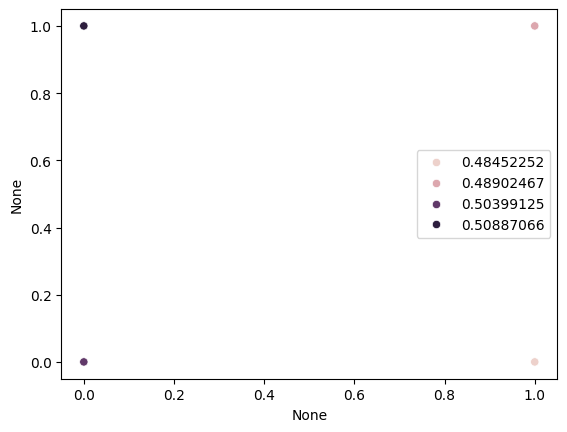

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the toy neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # Input: 2 features (XOR inputs), 2 hidden units
        self.fc2 = nn.Linear(2, 1)  # Output: 1 scalar output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x




# XOR dataset
#X = torch.rand_like(100,2)
#Y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Instantiate the model, loss function, and optimizer
model = SimpleNet()
# Initialize model parameters to random values
#for param in model.parameters():
#    param.data = -.5+torch.rand_like(param)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=.1)

dataloader = DataLoader(TensorDataset(X, Y), batch_size=64, shuffle=True)

# Training loop
for epoch in range(100):
  for x_batch, y_batch in dataloader:
    optimizer.zero_grad()
    outputs = model(X)
    # Calculate loss without modifying y_batch
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Observe if it converges to a local minimum
Y_pred = model(X)

sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y_pred.flatten().float().detach().numpy())

for param in model.parameters(): print(param)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # Input layer -> Hidden layer (2 neurons)
        self.fc2 = nn.Linear(2, 1)  # Hidden layer -> Output layer (1 neuron)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))  # Apply sigmoid after first layer
        x = self.sigmoid(self.fc2(x))  # Apply sigmoid after second layer
        return x

# XOR dataset (inputs and expected outputs)
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)  # XOR inputs
Y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)  # XOR outputs

# Instantiate the model, loss function, and optimizer
model = XORNet()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent optimizer

# DataLoader for batch processing
dataloader = DataLoader(TensorDataset(X, Y), batch_size=4, shuffle=True)

# Training loop
for epoch in range(10000):  # Train for 10,000 epochs
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Calculate loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Test the trained model
with torch.no_grad():
    predictions = model(X)
    print("\nPredictions after training:")
    print(predictions)

    # Round the predictions to 0 or 1 for binary classification
    binary_predictions = torch.round(predictions)
    print("\nBinary Predictions (Rounded):")
    print(binary_predictions)


Epoch 0, Loss: 0.6940107345581055
Epoch 1000, Loss: 0.6926224827766418
Epoch 2000, Loss: 0.6910852193832397
Epoch 3000, Loss: 0.6782428026199341
Epoch 4000, Loss: 0.4693261981010437
Epoch 5000, Loss: 0.1397436559200287
Epoch 6000, Loss: 0.06500802934169769
Epoch 7000, Loss: 0.040623798966407776
Epoch 8000, Loss: 0.029159536585211754
Epoch 9000, Loss: 0.022612782195210457

Predictions after training:
tensor([[0.0179],
        [0.9761],
        [0.9839],
        [0.0150]])

Binary Predictions (Rounded):
tensor([[0.],
        [1.],
        [1.],
        [0.]])


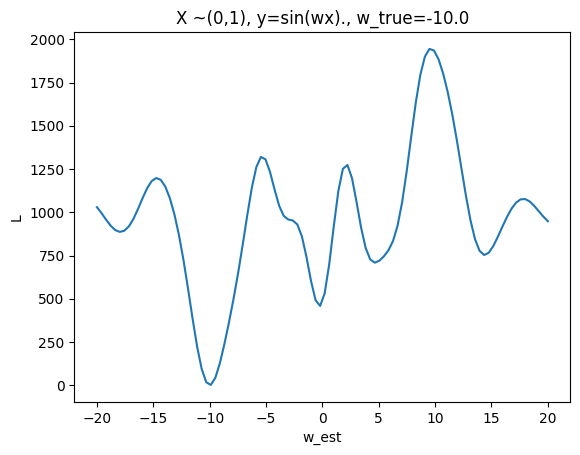

In [ ]:
x = np.random.random(1000)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

for w_true in np.linspace(-10,10):
  #y = np.tanh(w_true*x)
  w_ests  = np.linspace(-20,20, 100)
  L  = [sum((np.sin(w_true*x) - np.sin(w_est*x))**2) for w_est in w_ests]
  plt.plot(w_ests, L)
  plt.title(f'X ~(0,1), y=sin(wx)., w_true={w_true}')
  plt.xlabel('w_est')
  plt.ylabel('L')
  plt.show()

  break

# Base model

[tensor([[ 0.1534],
        [-0.3103]]), tensor([ 0.0768, -0.2162]), tensor([[0.1364, 0.4098],
        [0.1585, 0.3280]]), tensor([-0.3000,  0.2731])]


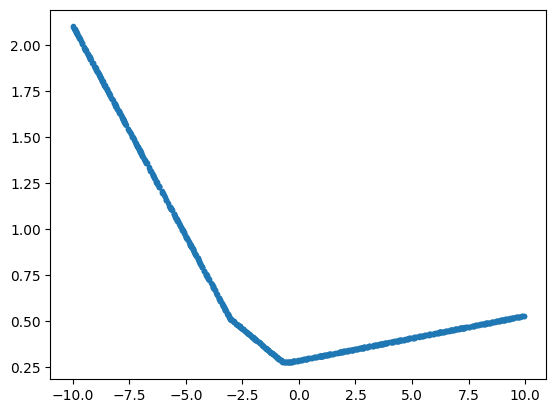

In [ ]:
# Initialize model

# Simple linear model
class LinearRegressionNN(nn.Module):
    def __init__(self, hidden_nodes=(1,1)):
        super(LinearRegressionNN, self).__init__()

        self.linear1 = nn.Linear(1, hidden_nodes[0], bias=True)  # One input, one output
        self.linear2 = nn.Linear(hidden_nodes[0], hidden_nodes[1], bias=True)  # One input, one output
        self.output = nn.Linear(hidden_nodes, 1, bias=False)  # One input, one output

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        return x.sum(dim=1)#self.output(x)#(dim=1)


base_model = LinearRegressionNN(hidden_nodes=(2,2)).requires_grad_(False)
# Set parameters in model to random numbers
for param in base_model.parameters():
    param.data = -.5+torch.rand_like(param)


base_model.eval()
X_tensor = torch.tensor(-10+20*np.random.rand(1000, 1)).float()#.unsqueeze(dim=1)
y_tensor = base_model(X_tensor)
plt.plot(X_tensor.numpy().flatten(), y_tensor.detach().numpy().flatten(), '.')


print([i.data for i in base_model.parameters()])


In [ ]:
# Loss landscape

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

n_iter = 10000
loss_fn = nn.MSELoss()
loss_model = LinearRegressionNN(hidden_nodes=2).requires_grad_(False)
params = torch.zeros(n_iter, torch.concat([i.data.flatten() for i in loss_model.parameters()]).shape[0])
losses = torch.zeros(n_iter)
# For a random set of parameters, compute the loss
for i in range(n_iter):
  for param_i, param in enumerate(loss_model.parameters()):
      param.data = -.5+torch.rand_like(param)
  params[i] = torch.concat([i.data.flatten() for i in loss_model.parameters()])
  losses[i] = loss_fn(loss_model(X_tensor), y_tensor)


TypeError: 'int' object is not subscriptable

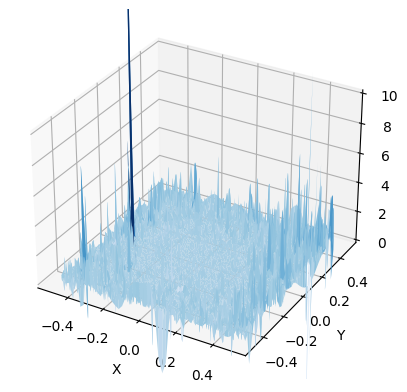

<ipython-input-366-6d6b88f02aed>:38: UserWarning: The following kwargs were not used by contour: 'ticker'
  cp = plt.contourf(grid_x, grid_y, grid_z, cmap='Blues', ticker=ticker.LogLocator())


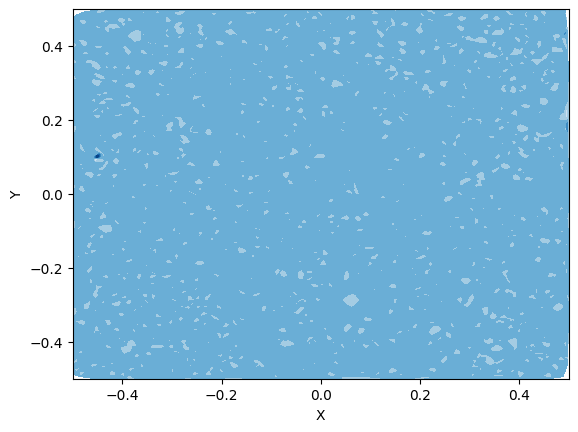

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Convert tensors to NumPy arrays
X = params.detach().numpy()[:,0]
Y = params.detach().numpy()[:,1]
Z = losses

# Create a grid to interpolate the scattered data
grid_x, grid_y = np.mgrid[-.5:.5:1000j, -.5:.5:1000j]  # 100x100 grid

# Interpolate the scattered data onto the grid
grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')

# Create the surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='Blues')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(0,10)

# Show the plot
plt.show()

from matplotlib import cm, ticker


# Create the contour plot
plt.figure()
cp = plt.contourf(grid_x, grid_y, grid_z, cmap='Blues', ticker=ticker.LogLocator())

# Add labels
plt.xlabel('X')
plt.ylabel('Y')

# Add colorbar
plt.show()

## Perfectly parameterized model

Epoch [100/1000], Loss: 0.0076
[tensor([[-0.4169],
        [-0.4541]]), tensor([ 0.0020, -0.0231]), tensor([[ 0.9613, -1.1522],
        [-0.2805,  0.7247]]), tensor([ 0.3198, -0.0473])]
Epoch [200/1000], Loss: 0.0026
[tensor([[-0.4005],
        [-0.4649]]), tensor([-0.0105, -0.0206]), tensor([[ 0.9514, -1.1628],
        [-0.2902,  0.7144]]), tensor([ 0.3800, -0.0804])]
Epoch [300/1000], Loss: 0.0036
[tensor([[-0.3956],
        [-0.4687]]), tensor([-0.0181, -0.0179]), tensor([[ 0.9488, -1.1659],
        [-0.2924,  0.7118]]), tensor([ 0.3951, -0.0988])]
Epoch [400/1000], Loss: 0.0032
[tensor([[-0.3953],
        [-0.4694]]), tensor([-0.0228, -0.0157]), tensor([[ 0.9490, -1.1657],
        [-0.2918,  0.7125]]), tensor([ 0.4002, -0.1100])]
Epoch [500/1000], Loss: 0.0035
[tensor([[-0.3968],
        [-0.4689]]), tensor([-0.0261, -0.0136]), tensor([[ 0.9502, -1.1643],
        [-0.2901,  0.7144]]), tensor([ 0.4021, -0.1180])]
Epoch [600/1000], Loss: 0.0026
[tensor([[-0.3990],
        [-0.4680]])

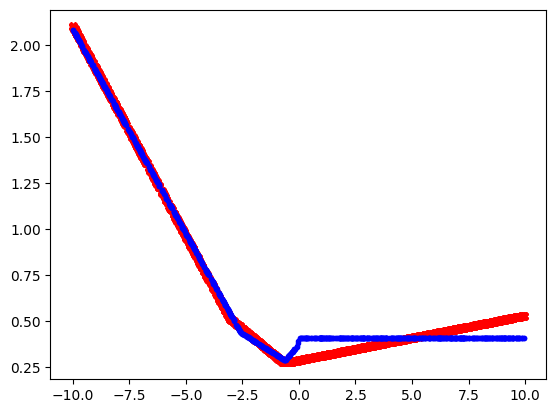

In [ ]:
# Initialize model
model = LinearRegressionNN(hidden_nodes=(2,2))

# Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        try:
          torch.nn.init.xavier_uniform_(m.weight)
          torch.nn.init.zeros_(m.bias)  # Initialize bias to zero
        except:
          pass
model.apply(init_weights)


# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.1)  # Lower learning rate

# Training loop
num_epochs = 1000  # Increase number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print([i.data for i in model.parameters()])
# Test model
model.eval()
with torch.no_grad():
    test_X = torch.tensor([[0.5]])
    test_prediction = model(test_X)
    print(f'Prediction for input 0.5: {test_prediction.item()}')



pred_y = model(X_tensor).detach().numpy().flatten()
true_y = base_model(X_tensor).detach().numpy().flatten()
plt.plot(X_tensor, true_y, 'rX')
plt.plot(X_tensor, pred_y, 'b.')

# Overparameterized model

Epoch [100/1000], Loss: 0.7206
[tensor([[ 0.0410],
        [ 0.0961],
        [-0.7279]]), tensor([ 0.0161, -0.0284,  0.0000]), tensor([[-0.8384,  0.4151, -0.2631],
        [-0.6359,  0.0119, -0.3619],
        [ 0.4961,  0.5207, -0.4319]]), tensor([-0.0303,  0.0000, -0.0069])]
Epoch [200/1000], Loss: 0.7847
[tensor([[ 0.0252],
        [ 0.0701],
        [-0.7273]]), tensor([ 0.0635,  0.0154, -0.0031]), tensor([[-0.8387,  0.4145, -0.2631],
        [-0.6359,  0.0119, -0.3619],
        [ 0.4983,  0.5165, -0.4310]]), tensor([-0.0311,  0.0000,  0.0871])]
Epoch [300/1000], Loss: 0.7814
[tensor([[ 0.0148],
        [ 0.0525],
        [-0.7246]]), tensor([ 0.0946,  0.0457, -0.0115]), tensor([[-0.8389,  0.4141, -0.2631],
        [-0.6359,  0.0119, -0.3619],
        [ 0.5026,  0.5165, -0.4266]]), tensor([-0.0317,  0.0000,  0.1484])]
Epoch [400/1000], Loss: 0.6608
[tensor([[ 0.0084],
        [ 0.0420],
        [-0.7202]]), tensor([ 0.1128,  0.0640, -0.0206]), tensor([[-0.8389,  0.4140, -0.2631],
 

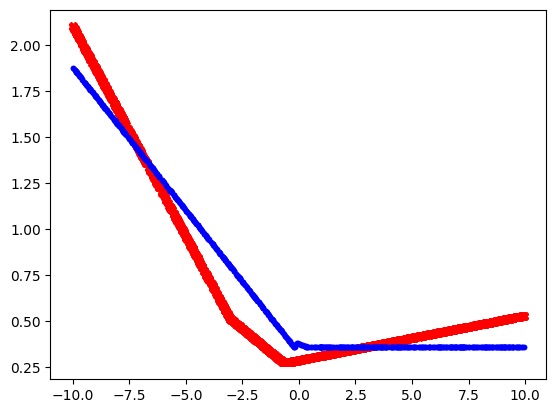

In [ ]:
# Initialize model
model = LinearRegressionNN(hidden_nodes=(3,3))

# Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        try:
          torch.nn.init.xavier_uniform_(m.weight)
          torch.nn.init.zeros_(m.bias)  # Initialize bias to zero
        except:
          pass
model.apply(init_weights)


# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.1)  # Lower learning rate

# Training loop
num_epochs = 1000  # Increase number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print([i.data for i in model.parameters()])
# Test model
model.eval()
with torch.no_grad():
    test_X = torch.tensor([[0.5]])
    test_prediction = model(test_X)
    print(f'Prediction for input 0.5: {test_prediction.item()}')



pred_y = model(X_tensor).detach().numpy().flatten()
true_y = base_model(X_tensor).detach().numpy().flatten()
plt.plot(X_tensor, true_y, 'rX')
plt.plot(X_tensor, pred_y, 'b.')

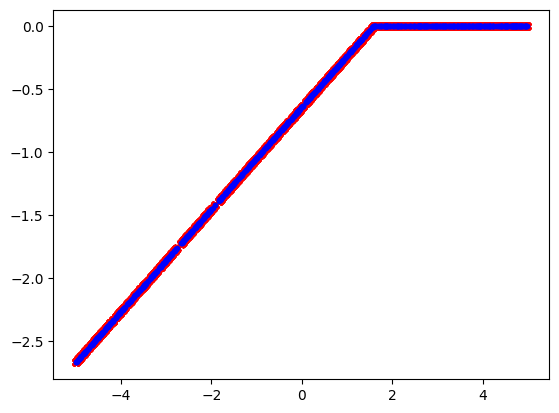

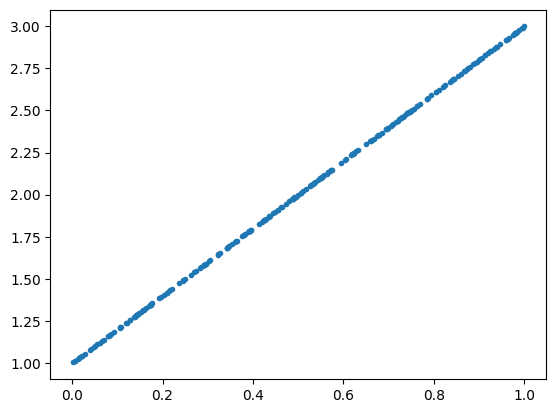

In [ ]:
def LinearFunction(seed_val, x):
  np.random.seed(seed_val+2)
  return 2*x + 1#np.random.random()*x + np.random.random()

def piecewise(x, max=2):
  for k in range(max+1):
    if x <= k:
      return LinearFunction(k, x)


max = 1

# Generate 100 random numbers between -10 and 10
x_vals = np.random.uniform(0, max, size=(256,1)).astype(float)


#functions = {i: lambda x: LinearFunction(i+11, x) for i in range(-10, 11)}
y = np.array([piecewise(x, max) for x in x_vals.flatten()]) #+ .1*np.random.randn(len(x_vals)).astype(float)
plt.plot(x_vals.flatten(), y.flatten(), '.')


In [ ]:


# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define two hidden layers with 12 nodes each
        #self.hidden1 = nn.Linear(1, 2)  # 1 input node to 12 hidden nodes
        #self.hidden2 = nn.Linear(2, 2) # 12 hidden nodes to 12 hidden nodes
        #self.output = nn.Linear(2, 1)   # 12 hidden nodes to 1 output node
        self.output2 = nn.Linear(1, 1)   # 12 hidden nodes to 1 output node
        torch.nn.init.xavier_uniform_(self.output2.weight)
        torch.nn.init.zeros_(self.output2.bias)  # Initialize bias to zero
        # Initialize parameters
        #nn.init.xavier_uniform_(self.hidden1.weight)
        #nn.init.xavier_uniform_(self.hidden2.weight)
        #nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        #x = torch.relu(self.hidden1(x))  # ReLU activation function for first layer
        #x = torch.relu(self.hidden2(x))  # ReLU activation function for second layer
        x = self.output2(x)               # Output layer without activation (regression)
        return x

# Initialize the model


In [ ]:

# Convert numpy arrays to PyTorch tensors
x_vals = np.random.uniform(0, max, size=(256,1)).astype(float)

X_tensor = torch.tensor(x_vals).float().unsqueeze(dim=1)
y_tensor = torch.tensor(y).float()

# Create a DataLoader for mini-batch processing
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
# Define the loss function (MSE for regression)
loss_fn = nn.MSELoss()
model = SimpleNN()
# Define the optimizer (Adam)
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
print(list(model.parameters()))

[Parameter containing:
tensor([[1.6599]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


In [ ]:
# Training loop
num_epochs = 1000  # You can change this depending on your dataset and problem
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute predictions
        predictions = model(batch_X)

        # Compute the loss
        loss = loss_fn(predictions, batch_y)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights
        optimizer.step()
    # Print the loss every 50 epochs for monitoring
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(list(model.parameters()))



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [50/1000], Loss: 0.7088
[Parameter containing:
tensor([[1.8733]], requires_grad=True), Parameter containing:
tensor([0.8587], requires_grad=True)]
Epoch [100/1000], Loss: 0.3888
[Parameter containing:
tensor([[1.7510]], requires_grad=True), Parameter containing:
tensor([1.0518], requires_grad=True)]
Epoch [150/1000], Loss: 0.5810
[Parameter containing:
tensor([[1.5987]], requires_grad=True), Parameter containing:
tensor([1.1507], requires_grad=True)]
Epoch [200/1000], Loss: 0.3191
[Parameter containing:
tensor([[1.4558]], requires_grad=True), Parameter containing:
tensor([1.2303], requires_grad=True)]
Epoch [250/1000], Loss: 0.6329
[Parameter containing:
tensor([[1.3250]], requires_grad=True), Parameter containing:
tensor([1.3016], requires_grad=True)]
Epoch [300/1000], Loss: 0.4535
[Parameter containing:
tensor([[1.2084]], requires_grad=True), Parameter containing:
tensor([1.3653], requires_grad=True)]
Epoch [350/1000], Loss: 0.2794
[Parameter containing:
tensor([[1.1030]], requ

In [ ]:
# Evaluate the model on new data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients during inference
    y_test = model(X_tensor)
    print(loss_fn(y_test, y_tensor))
a
plt.plot(X_tensor, y_tensor, '.')
plt.plot(X_tensor, y_test, '.')

tensor(0.3376)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: name 'a' is not defined

In [ ]:

loss_fn(y_test, y_tensor)

In [ ]:
for p in model.parameters(): print(p)

In [ ]:
model(torch.Tensor([1000]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Simple linear model
class LinearRegressionNN(nn.Module):
    def __init__(self):
        super(LinearRegressionNN, self).__init__()

        self.linear1 = nn.Linear(1, 2)  # One input, one output
        self.linear3 = nn.Linear(2, 1)  # One input, one output

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return self.linear3(x)

# Initialize model
model = LinearRegressionNN()

# Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)  # Initialize bias to zero

model.apply(init_weights)
# Convert to tensors
X_tensor = torch.tensor(X)
y_tensor = abs(X_tensor)torch.tensor(y, requires_gard = )

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# Training loop
num_epochs = 5000  # Increase number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test model
model.eval()
with torch.no_grad():
    test_X = torch.tensor([[0.5]])
    test_prediction = model(test_X)
    print(f'Prediction for input 0.5: {test_prediction.item()}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 1x2)

# Base model

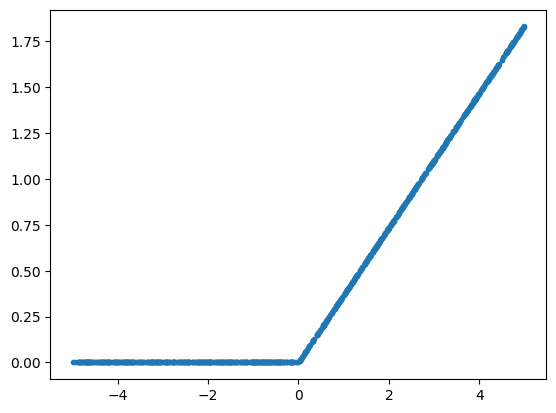

In [ ]:
# Initialize model

# Simple linear model
class LinearRegressionNN(nn.Module):
    def __init__(self, hidden_nodes):
        super(LinearRegressionNN, self).__init__()

        self.linear1 = nn.Linear(1, hidden_nodes, bias=False)  # One input, one output
        self.output = nn.Linear(hidden_nodes, 1, bias=False)  # One input, one output

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return  self.output(x)


base_model = LinearRegressionNN(hidden_nodes=1).requires_grad_(False)
# Set parameters in model to random numbers
for param in base_model.parameters():
    param.data = torch.randn_like(param)


base_model.eval()
X_tensor = torch.tensor(-5+10*np.random.rand(1000, 1)).float()#.unsqueeze(dim=1)
y_tensor = base_model(X_tensor)
plt.plot(X_tensor.numpy().flatten(), y_tensor.detach().numpy().flatten(), '.')





In [ ]:

# Initialize model
model = LinearRegressionNN(hidden_nodes=1)

# Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        try:
          torch.nn.init.xavier_uniform_(m.weight)
          torch.nn.init.zeros_(m.bias)  # Initialize bias to zero
        except:
          pass
model.apply(init_weights)


# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Lower learning rate

# Training loop
num_epochs = 5000  # Increase number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

    #if (epoch+1) % 100 == 0:
    #    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    #    print([i.data for i in model.parameters()])
# Test model
model.eval()
with torch.no_grad():
    test_X = torch.tensor([[0.5]])
    test_prediction = model(test_X)
    print(f'Prediction for input 0.5: {test_prediction.item()}')

NameError: name 'LinearRegressionNN' is not defined

In [ ]:

# Initialize model
model = LinearRegressionNN(hidden_nodes=2)

# Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.zeros_(m.bias)  # Initialize bias to zero

model.apply(init_weights)


# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Lower learning rate

# Training loop
num_epochs = 5000  # Increase number of epochs
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print([i.data for i in model.parameters()])
# Test model
model.eval()
with torch.no_grad():
    test_X = torch.tensor([[0.5]])
    test_prediction = model(test_X)
    print(f'Prediction for input 0.5: {test_prediction.item()}')


print([i.data for i in base_model.parameters()])

pred_y = model(X_tensor).detach().numpy().flatten()
true_y = base_model(X_tensor).detach().numpy().flatten()
plt.plot(X_tensor, true_y, 'rX')
plt.plot(X_tensor, pred_y, 'b.')








Epoch [100/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]
Epoch [200/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]
Epoch [300/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]
Epoch [400/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]
Epoch [500/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]
Epoch [600/5000], Loss: 0.0000
[tensor([[0.6933],
        [1.2056]]), tensor([[-0.0766,  0.3486]])]


KeyboardInterrupt: 

[tensor([[0.6013]]), tensor([[0.6107]])]


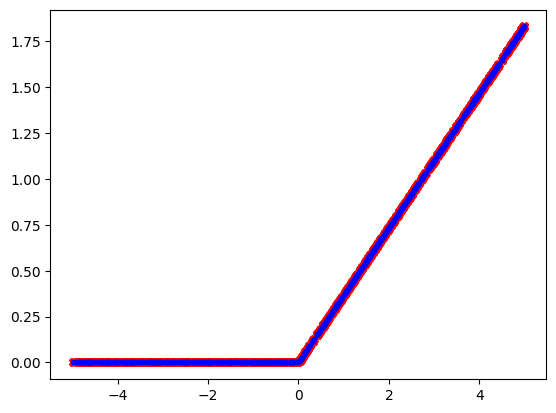

In [ ]:
pred_y = model(X_tensor).detach().numpy().flatten()
true_y = base_model(X_tensor).detach().numpy().flatten()
plt.plot(X_tensor, true_y, 'rX')
plt.plot(X_tensor, pred_y, 'b.')








In [ ]:
for i in model.parameters(): print(i)
for i in base_model.parameters(): print(i)

Parameter containing:
tensor([[-0.6692],
        [ 1.0516]], requires_grad=True)
Parameter containing:
tensor([-0.1967,  1.2103], requires_grad=True)
Parameter containing:
tensor([[-9.4155e-08,  6.5090e-01]], requires_grad=True)
Parameter containing:
tensor([0.8643], requires_grad=True)
Parameter containing:
tensor([[1.0464]])
Parameter containing:
tensor([1.2043])
Parameter containing:
tensor([[0.6541]])
Parameter containing:
tensor([0.8643])
